## Imports

In [1]:
import os
import io
import re
import cv2 
import subprocess
import time
import uuid
import pathlib
from datetime import datetime

import xml.etree.ElementTree as ET
import xml.dom.minidom as minidom

import csv
import glob

import random
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from scipy.signal import savgol_filter
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display

from object_detection.builders import model_builder
from object_detection.utils import config_util
from object_detection.utils import label_map_util
from object_detection.utils import ops as utils_ops
from object_detection.utils import visualization_utils as vis_util

from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

In [ ]:
# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

In [ ]:
base_config_path = './pipeline.config'

configs = config_util.get_configs_from_pipeline_file(base_config_path)
model_config = configs['model']
detection_model = model_builder.build(model_config=model_config, is_training=False)

print("Model was successfully built")

In [2]:
#Checking for gpu
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
   raise SystemError('GPU device not found')

print('Found GPU at: {}'.format(device_name))
print(tf.__version__)

Found GPU at: /device:GPU:0
2.10.1


## Setup

In [2]:
random.seed(42)
np.random.seed(21)
tf.compat.v1.random.set_random_seed(42)

In [3]:
# Id_mapping:
    # 1:'Speed limit (30km/h)', 
    # 2:'Speed limit (50km/h)',
    # 12:'Priority road', 
    # 14:'Stop', 
    # 17:'No entry',
    # 41:'Ende des Überholverbots',

In [133]:
SAMPLE_SIZE_TRAIN = 50 # Default: 50 Images of each class excluding values in :id_mapping. Used for Trainset
SAMPLE_SIZE_TEST = 10 # Default: 10 Images of each class excluding values in :id_mapping . Used for Testset

IMAGE_WIDTH = 320 # Image width in pixels to resize for visualization
IMAGE_HEIGHT = 320 # Image height in pixels to resize for visualization

train_path = './GTSRB/Final_Training/Images' # Location of the training images
test_path = './GTSRB/Final_Test/Images' # Location of the test images

id_mapping = {1: 1, 2: 2, 12: 3, 14: 4, 17: 5}
unknown_label = 6

In [5]:
BASE_MODEL = "efficientdet_d4_coco17_tpu-32"
MODEL_NAME = "Efficientdet_12000_1024_d4"
IS_SSD = True # True if SSD model is used. False otherwise 
TRANSERLEARNING = False # True if you want to retrain your model 

BATCH_SIZE = 3
NUM_CLASSES = 5
NUM_STEPS = 13000
NUM_EVAL_STEPS = 1000
use_bfloat16 = False # Use bfloat16 True for TPU

NOTES = "" # Training Notes for the log 

In [6]:
# Used for Evaluation
if IS_SSD:
    TRAINED_CONFIG_PATH = "./myModules/configs/{name}_config.config".format(name=MODEL_NAME)
    TRAINED_CHECKPOINT_PATH = 'D:\\Desktop-Short\\trained_models\\ssd\\{name}'.format(name=MODEL_NAME)
    TRAINED_LABLE_MAP_PATH = "./myModules/label_map_short_woUnk.pbtxt"
    MODEL_TYPE = "ssd"
else:
    TRAINED_CONFIG_PATH = "./myModules/configs/{name}_config.config".format(name=MODEL_NAME)
    TRAINED_CHECKPOINT_PATH = 'D:\\Desktop-Short\\trained_models\\faster_rcnn\\{name}'.format(name=MODEL_NAME)
    TRAINED_LABLE_MAP_PATH = "./myModules/label_map_short_woUnk.pbtxt"
    MODEL_TYPE = "faster_rcnn"

In [7]:
if TRANSERLEARNING:
        base_config_path = "./inference/faster_rcnn/{name}/pipeline.config".format(name=BASE_MODEL)
        base_checkpoint_path = "./inference/faster_rcnn/{name}/checkpoint/ckpt-0".format(name=BASE_MODEL)

        # Save to path
        model_dir = 'D:\\Desktop-Short\\trained_models\\faster_rcnn\\{name}'.format(name=MODEL_NAME)
        config_path = './myModules/configs/{name}_config.config'.format(name=MODEL_NAME)

        # Upload from path
        labelmap_path = "./myModules/label_map_short.pbtxt"
        train_record_path = "./myModules/records/train.record"
        test_record_path = "./myModules/records/test.record"
        
        inference_path = './inference/faster_rcnn/{name}'.format(name=MODEL_NAME)
else:
    if IS_SSD:
        # Download from path 
        base_config_path = "./base_models/ssd/{name}/pipeline.config".format(name=BASE_MODEL)
        base_checkpoint_path = "./base_models/ssd/{name}/checkpoint/ckpt-0".format(name=BASE_MODEL)

        # Save to path
        model_dir = 'D:\\Desktop-Short\\trained_models\\ssd\\{name}'.format(name=MODEL_NAME)
        config_path = './myModules/configs/{name}_config.config'.format(name=MODEL_NAME)

        # Upload from path
        labelmap_path = "./myModules/label_map_short_woUnk.pbtxt"
        train_record_path = "./myModules/records/trainWoUnknown.record"
        test_record_path = "./myModules/records/testWoUnknown.record"
        
        inference_path = './inference/ssd/{name}'.format(name=MODEL_NAME)
    else:
        base_config_path = "D:\\Desktop-Short\\base_models\\faster_rcnn\\{name}\\pipeline.config".format(name=BASE_MODEL)
        base_checkpoint_path = "D:\\Desktop-Short\\base_models\\{name}\\checkpoint\\ckpt-0".format(name=BASE_MODEL)

        # Save to path
        model_dir = 'D:\\Desktop-Short\\trained_models\\faster_rcnn\\{name}'.format(name=MODEL_NAME)
        config_path = './myModules/configs/{name}_config.config'.format(name=MODEL_NAME)

        # Upload from path
        labelmap_path = "./myModules/label_map_short_woUnk.pbtxt"
        train_record_path = "./myModules/records/trainWoUnknown.record"
        test_record_path = "./myModules/records/testWoUnknown.record"
        
        inference_path = './inference/faster_rcnn/{name}'.format(name=MODEL_NAME)

## 1. Dataset

### Dataset Setup

In [8]:
def readTrafficSignsTrain(rootpath, cache_path):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.
    Arguments:
        rootpath: path to the traffic sign data, for example './GTSRB/Training'
        cache_path: path to the cached DataFrame file, default is 'traffic_signs_data.pkl'
    Returns:
        DataFrame containing labels, image shapes, ROIs, and image paths
    '''
    
    if os.path.exists(cache_path):
        print(f"Loading: {cache_path}")
        return pd.read_pickle(cache_path)

    data = []
    # loop over all 43 classes
    for c in range(0, 43):
        prefix = f"{rootpath}/{c:05d}/"  # subdirectory for class
        gtFile = open(prefix + f'GT-{c:05d}.csv')  # annotations file
        gtReader = csv.reader(gtFile, delimiter=';')  # csv parser for annotations file
        next(gtReader)  # skip header

        # loop over all images in current annotations file
        for row in gtReader:
            img_path = prefix + row[0]
            img = plt.imread(img_path)  # load image
 
            label = int(row[7])  # the 8th column is the label
            height = img.shape[0]  # height of the image
            width = img.shape[1]  # width of the image
            #channels = img.shape[2] if len(img.shape) > 2 else 1  # channels of the image (default to 1 if grayscale)
            roi_x1 = int(row[3])  # ROI X1 coordinate
            roi_y1 = int(row[4])  # ROI Y1 coordinate
            roi_x2 = int(row[5])  # ROI X2 coordinate
            roi_y2 = int(row[6])  # ROI Y2 coordinate

            data.append([width, height, roi_x1, roi_y1, roi_x2, roi_y2, img_path, label])

        gtFile.close()

    df = pd.DataFrame(data, columns=['Width', 'Height','Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2', 'Path', 'Label'])
    
    df.to_pickle(cache_path)
    print(f"Dataframe saved in: {cache_path}")
    
    return df

In [9]:
def readTrafficSignsTest(rootpath, cache_path):
    '''Reads the final test data for the German Traffic Sign Recognition Benchmark.
    Arguments: path to the final test data, for example './GTSRB/Final_Test/Images'
    Returns: DataFrame with image data, labels, image shapes, and ROI
    '''
    
    if os.path.exists(cache_path):
        print(f"Loading: {cache_path}")
        return pd.read_pickle(cache_path)

    # Pfad zur CSV-Datei
    csv_file = os.path.join(rootpath, 'GT-final_test_gt.csv')
    
    # Lade die CSV-Datei
    df = pd.read_csv(csv_file, delimiter=';')
    
    # Liste zum Speichern der Daten
    data = []
    
    # Schleife über alle Zeilen der CSV-Datei
    for _, row in df.iterrows():
        img_path = os.path.join(rootpath, row['Filename'])
        img = plt.imread(img_path)  # Lade das Bild
        
        if img is not None:
            label = int(row['ClassId'])
            height, width, channels = img.shape
            roi_x1 = int(row['Roi.X1'])
            roi_y1 = int(row['Roi.Y1'])
            roi_x2 = int(row['Roi.X2'])
            roi_y2 = int(row['Roi.Y2'])
            
            # Füge die Daten als Zeile hinzu
            data.append([width, height, roi_x1, roi_y1, roi_x2, roi_y2, img_path, label])
        else:
            print(f"Bild {img_path} konnte nicht geladen werden.")
    
    # Erstelle ein DataFrame aus der Liste
    df_test = pd.DataFrame(data, columns=['Width', 'Height','Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2', 'Path', 'Label'])
    df_test.to_pickle(cache_path)
    print(f"Dataframe saved in: {cache_path}")
    return df_test

In [10]:
def load_image_into_numpy_array(path):
    image = Image.open(path)
    image = image.resize((IMAGE_WIDTH, IMAGE_HEIGHT))  # Resize to 280x280
    return np.array(image).astype(np.uint8)

In [11]:
def reassign_labels(df, selected_labels, unknown_label, sample_size):
    """
    Reassign labels in the dataframe according to selected_labels.
    Keep all rows for the labels in selected_labels.
    For remaining labels, sample a specified number of rows and reassign them to unknown_label.

    Parameters:
    df (pd.DataFrame): The input dataframe with a column named 'Label'.
    selected_labels (dict): A dictionary mapping old labels to new labels.
    unknown_label (int): The label to assign to the remaining sampled rows.
    sample_size (int): The number of rows to sample for each remaining label. Default is 15.

    Returns:
    pd.DataFrame: A new dataframe with reassigned labels.
    """
    new_df = pd.DataFrame()

    for old_label, new_label in selected_labels.items():
        label_df = df[df['Label'] == old_label].copy()
        label_df['Label'] = new_label
        new_df = pd.concat([new_df, label_df])

    unique_labels = df['Label'].unique()
    remaining_labels = [label for label in unique_labels if label not in selected_labels]

    for label in remaining_labels:
        label_df = df[df['Label'] == label]
        if len(label_df) > sample_size:
            selected_rows = label_df.sample(n=sample_size, random_state=42)
        else:
            selected_rows = label_df
        selected_rows['Label'] = unknown_label
        new_df = pd.concat([new_df, selected_rows])

    new_df.reset_index(drop=True, inplace=True)

    return new_df

### 1.0 Create Dataset for YOLO

In [ ]:
PATH_TO_TRAIN_DF = "./myModules/data/df_train_raw.pkl"
PATH_TO_TEST_DF = "./myModules/data/df_test_raw.pkl"

PATH_TO_TRAIN_ANNOTATIONS = './yoloNoUnkData/Train/Annotations/'
PATH_TO_TRAIN_IMAGES = './yoloNoUnkData/Train/Images/'

PATH_TO_TEST_ANNOTATIONS = './yoloNoUnkData/Test/Annotations/'
PATH_TO_TEST_IMAGES = './yoloNoUnkData/Test/'

In [ ]:
def prettify_xml(elem):
    """Return a pretty-printed XML string for the Element.
    """
    rough_string = ET.tostring(elem, 'utf-8')
    reparsed = minidom.parseString(rough_string)
    return reparsed.toprettyxml(indent="  ")

In [ ]:
def create_voc_annotation_for_trainset(df, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    for _, row in df.iterrows():
        annotation = ET.Element('annotation')
        
        subfolder_name = os.path.basename(os.path.dirname(row['Path']))
        
        # Create unique filename with subfolder prefix (e.g., '0000_00000_00000.xml')
        os.path.basename(row['Path']).replace('.ppm', '.jpg')
        filename = f"{subfolder_name}_{os.path.splitext(os.path.basename(row['Path']))[0]}.xml"
        
        ET.SubElement(annotation, 'folder').text = 'Images'
        ET.SubElement(annotation, 'filename').text = filename.replace('.xml', '.jpg')
        
        size = ET.SubElement(annotation, 'size')
        ET.SubElement(size, 'width').text = str(row['Width'])
        ET.SubElement(size, 'height').text = str(row['Height'])
        ET.SubElement(size, 'depth').text = '3' 

        segmented = ET.SubElement(annotation, 'segmented').text = '0'
        
        obj = ET.SubElement(annotation, 'object')
        ET.SubElement(obj, 'name').text = str(row['Label'])
        ET.SubElement(obj, 'pose').text = 'Unspecified'
        ET.SubElement(obj, 'truncated').text = '0'
        ET.SubElement(obj, 'difficult').text = '0'
        
        bndbox = ET.SubElement(obj, 'bndbox')
        ET.SubElement(bndbox, 'xmin').text = str(row['Roi.X1'])
        ET.SubElement(bndbox, 'ymin').text = str(row['Roi.Y1'])
        ET.SubElement(bndbox, 'xmax').text = str(row['Roi.X2'])
        ET.SubElement(bndbox, 'ymax').text = str(row['Roi.Y2'])
        
        output_file = os.path.join(output_dir, filename)
        with open(output_file, 'w') as f:
            f.write(prettify_xml(annotation))

In [ ]:
def create_voc_annotation_for_testset(df, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for index, row in df.iterrows():
        annotation = ET.Element('annotation')
        ET.SubElement(annotation, 'folder').text = 'Images'
        ET.SubElement(annotation, 'filename').text = os.path.basename(row['Path']).replace('.ppm', '.jpg')
        
        size = ET.SubElement(annotation, 'size')
        ET.SubElement(size, 'width').text = str(row['Width'])
        ET.SubElement(size, 'height').text = str(row['Height'])
        ET.SubElement(size, 'depth').text = '3' 
        
        segmented = ET.SubElement(annotation, 'segmented').text = '0'
        
        obj = ET.SubElement(annotation, 'object')
        ET.SubElement(obj, 'name').text = str(row['Label'])
        ET.SubElement(obj, 'pose').text = 'Unspecified'
        ET.SubElement(obj, 'truncated').text = '0'
        ET.SubElement(obj, 'difficult').text = '0'
        
        bndbox = ET.SubElement(obj, 'bndbox')
        ET.SubElement(bndbox, 'xmin').text = str(row['Roi.X1'])
        ET.SubElement(bndbox, 'ymin').text = str(row['Roi.Y1'])
        ET.SubElement(bndbox, 'xmax').text = str(row['Roi.X2'])
        ET.SubElement(bndbox, 'ymax').text = str(row['Roi.Y2'])
        
        # Write XML file with pretty print
        output_file = os.path.join(output_dir, os.path.basename(row['Path']).replace('.ppm', '.xml'))
        with open(output_file, 'w') as f:
            f.write(prettify_xml(annotation))

In [ ]:
def convert_ppm_to_jpg_from_df_train(df, jpg_root):
    if not os.path.exists(jpg_root):
        os.makedirs(jpg_root)
    
    for index, row in df.iterrows():
        img_path = row['Path']
        if img_path.endswith('.ppm'):
            img = Image.open(img_path)
            
            folder_name = os.path.basename(os.path.dirname(img_path))  
            filename = os.path.basename(img_path).replace('.ppm', '.jpg')
            jpg_filename = f"{folder_name}_{filename}"  
            
            jpg_path = os.path.join(jpg_root, jpg_filename)

            img.save(jpg_path, 'JPEG')

In [ ]:
def convert_ppm_to_jpg_from_df(df, jpg_dir):
    if not os.path.exists(jpg_dir):
        os.makedirs(jpg_dir)
    
    for _, row in df.iterrows():
        img_path = row['Path']
        if img_path.endswith('.ppm'):
            
            img = Image.open(img_path)
            subfolder = os.path.basename(os.path.dirname(img_path))
            filename = os.path.basename(img_path).replace('.ppm', '.jpg')
            jpg_subdir = os.path.join(jpg_dir, subfolder)
            
            if not os.path.exists(jpg_subdir):
                os.makedirs(jpg_subdir)
            jpg_path = os.path.join(jpg_subdir, filename)
            img.save(jpg_path, 'JPEG')

In [ ]:
#df = readTrafficSignsTrain(train_path, PATH_TO_TRAIN_DF)
create_voc_annotation_for_trainset(df_final_train, PATH_TO_TRAIN_ANNOTATIONS)
convert_ppm_to_jpg_from_df_train(df_final_train, PATH_TO_TRAIN_IMAGES)

In [ ]:
#df = readTrafficSignsTest(test_path, PATH_TO_TEST_DF)
create_voc_annotation_for_testset(df_final_test, PATH_TO_TEST_ANNOTATIONS)
convert_ppm_to_jpg_from_df(df_final_test, PATH_TO_TEST_IMAGES)

### 1.1 Read Dataset  

In [12]:
df_train_cache = readTrafficSignsTrain(train_path, "./myModules/data/df_train_raw.pkl")
df_train = pd.DataFrame()
df_train = df_train_cache.copy()

Loading: ./myModules/data/df_train_raw.pkl


In [13]:
df_test_cache = readTrafficSignsTest(test_path, "./myModules/data/df_test_raw.pkl")
df_test = pd.DataFrame()
df_test = df_test_cache.copy()

Loading: ./myModules/data/df_test_raw.pkl


In [14]:
df_final_train = reassign_labels(df_train, id_mapping, unknown_label, SAMPLE_SIZE_TRAIN)
df_final_test = reassign_labels(df_test, id_mapping, unknown_label, SAMPLE_SIZE_TEST)

In [15]:
# Run to exlude the unknown Labels
df_final_train = df_final_train[df_final_train['Label'] != 6]
df_final_test = df_final_test[df_final_test['Label'] != 6]

In [16]:
df_final_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2790 entries, 0 to 2789
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Width   2790 non-null   int64 
 1   Height  2790 non-null   int64 
 2   Roi.X1  2790 non-null   int64 
 3   Roi.Y1  2790 non-null   int64 
 4   Roi.X2  2790 non-null   int64 
 5   Roi.Y2  2790 non-null   int64 
 6   Path    2790 non-null   object
 7   Label   2790 non-null   int64 
dtypes: int64(7), object(1)
memory usage: 196.2+ KB


In [17]:
df_final_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8460 entries, 0 to 8459
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Width   8460 non-null   int64 
 1   Height  8460 non-null   int64 
 2   Roi.X1  8460 non-null   int64 
 3   Roi.Y1  8460 non-null   int64 
 4   Roi.X2  8460 non-null   int64 
 5   Roi.Y2  8460 non-null   int64 
 6   Path    8460 non-null   object
 7   Label   8460 non-null   int64 
dtypes: int64(7), object(1)
memory usage: 594.8+ KB


### 1.2 Verfify Dataset (shortened)

In [145]:
%matplotlib inline
short_classes = { 1: '30km/h (ID: 1)', 
                  2: '50km/h (ID: 2)', 
                  3: 'Vorrangstraße(ID: 3)', 
                  4: 'Stop(ID: 4)', 
                  5: 'Einfahrtverbot (ID: 5)',
                  6: 'Unbekannt(ID: 6)'}

In [ ]:
image_paths_to_display = df_final_train['Path'].tolist()
image_paths_to_display = random.sample(image_paths_to_display, min(len(image_paths_to_display), 100))

plt.figure(figsize=(10, 10))
for i, image_path in enumerate(image_paths_to_display, ):
    image_np = load_image_into_numpy_array(image_path)  # Funktion, um Bild in ein numpy array zu laden
    plt.subplot(10, 10, i + 1)
    plt.imshow(image_np)
    plt.axis('off')

plt.tight_layout()

In [ ]:
image_paths_to_display = df_final_test['Path'].tolist()
image_paths_to_display = random.sample(image_paths_to_display, min(len(image_paths_to_display), 100))

plt.figure(figsize=(10, 10))
for i, image_path in enumerate(image_paths_to_display):
    image_np = load_image_into_numpy_array(image_path)  # Funktion, um Bild in ein numpy array zu laden
    plt.subplot(10, 10, i + 1)
    plt.imshow(image_np)
    plt.axis('off')

plt.tight_layout()

In [140]:
unknown_label_df = df_final_train[df_final_train['Label'] == 6]

# Wähle zufällig 100 Bilder aus
image_paths_to_display = unknown_label_df['Path'].tolist()
image_paths_to_display = random.sample(image_paths_to_display, min(len(image_paths_to_display), 100))

# Plotten der ausgewählten Bilder
plt.figure(figsize=(10, 10))
for i, image_path in enumerate(image_paths_to_display):
    image_np = load_image_into_numpy_array(image_path)  # Funktion, um Bild in ein numpy array zu laden
    plt.subplot(10, 10, i + 1)
    plt.imshow(image_np)
    plt.axis('off')

plt.tight_layout()
plt.show()

<Figure size 1000x1000 with 0 Axes>

In [154]:
print(label_counts_final.sum())

8460


C:\Users\Alexej\AppData\Local\Temp\ipykernel_1916\305365456.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(label_counts_named_final.keys()), y=list(label_counts_named_final.values()), palette='viridis')


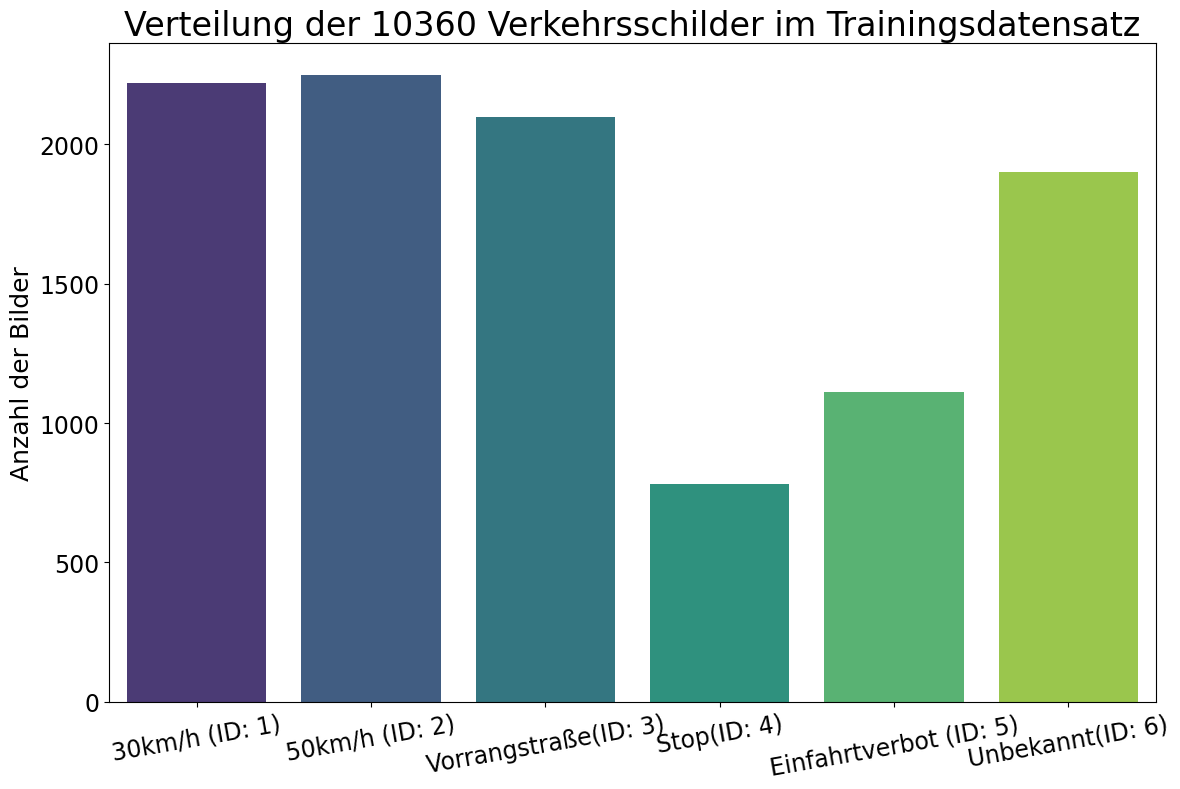

In [170]:
label_counts_final = df_final_train['Label'].value_counts().sort_index()

num_classes = len(label_counts_final)
total_images = label_counts_final.sum()
label_counts_named_final = {short_classes[key]: value for key, value in label_counts_final.items()}

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(x=list(label_counts_named_final.keys()), y=list(label_counts_named_final.values()), palette='viridis')
plt.ylabel('Anzahl der Bilder',fontsize=18)
plt.title(f'Verteilung der {total_images} Verkehrsschilder im Trainingsdatensatz',fontsize=24)
plt.xticks(rotation=10,fontsize=17)  

plt.yticks(fontsize=17)  
plt.tight_layout()
plt.show()

In [173]:
def load_brightness_values(image_paths):
    brightness_values = []
    for path in image_paths:
        img = cv2.imread(path)
        if img is not None:
            brightness = np.mean(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
            brightness_values.append(brightness)
    return brightness_values


brightness_values = load_brightness_values(df_final_train['Path'])
brightness_normalized = [v / 255.0 for v in brightness_values]

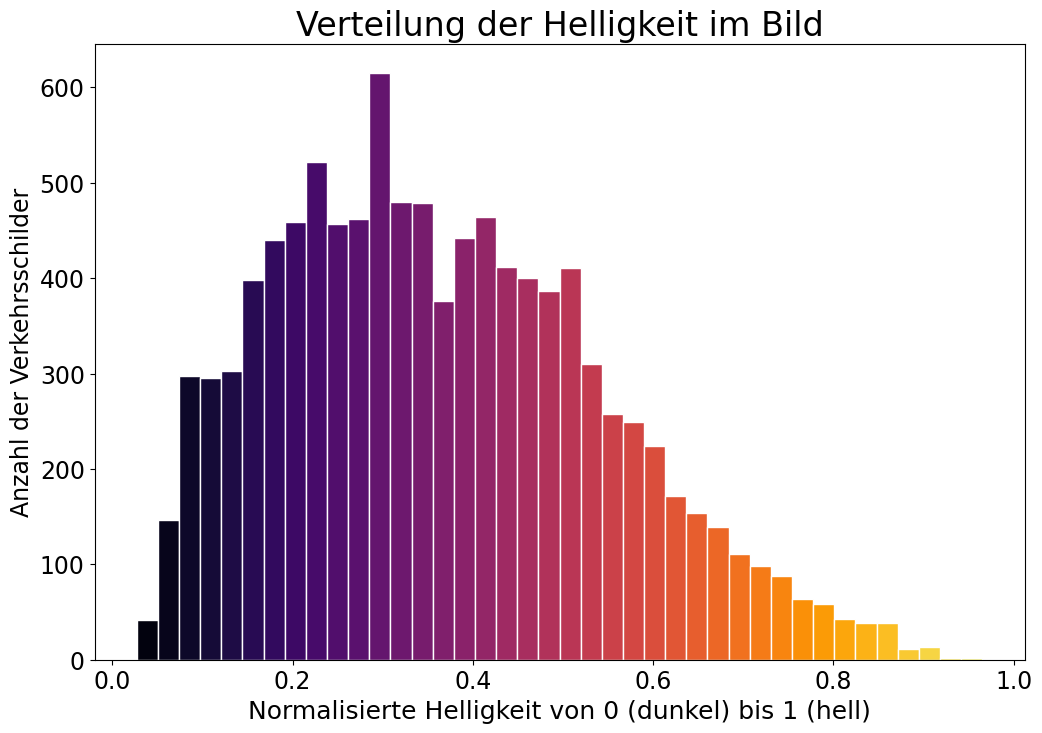

In [177]:
plt.figure(figsize=(12, 8))

counts, bins, patches = plt.hist(brightness_normalized, bins = 40, edgecolor = 'white')

norm = plt.Normalize(vmin=0, vmax=1)
sm = plt.cm.ScalarMappable(cmap='inferno', norm=norm)

for patch, value in zip(patches, bins):
    color = sm.to_rgba(value)
    patch.set_facecolor(color)


plt.xlabel('Normalisierte Helligkeit von 0 (dunkel) bis 1 (hell)', fontsize=18)
plt.xticks(fontsize=17)  
plt.yticks(fontsize=17)  
plt.ylabel('Anzahl der Verkehrsschilder', fontsize=17)
plt.title('Verteilung der Helligkeit im Bild', fontsize=24)


plt.show()

### 1.3 Create Tf-records

In [ ]:
def create_tf_example(row):
    img_path = row['Path']
    image = Image.open(img_path)
    image = image.convert("RGB")
    
    with io.BytesIO() as output:
        image.save(output, format="JPEG")
        encoded_jpg = output.getvalue()

    width, height = image.size

    filename = row['Path'].encode('utf8')
    image_format = b'jpeg'
    xmins = [row['Roi.X1'] / width]
    xmaxs = [row['Roi.X2'] / width]
    ymins = [row['Roi.Y1'] / height]
    ymaxs = [row['Roi.Y2'] / height]
    classes_text = [str(row['Label']).encode('utf8')]
    classes = [int(row['Label'])]

    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'image/width': tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'image/filename': tf.train.Feature(bytes_list=tf.train.BytesList(value=[filename])),
        'image/source_id': tf.train.Feature(bytes_list=tf.train.BytesList(value=[filename])),
        'image/encoded': tf.train.Feature(bytes_list=tf.train.BytesList(value=[encoded_jpg])),
        'image/format': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image_format])),
        'image/object/bbox/xmin': tf.train.Feature(float_list=tf.train.FloatList(value=xmins)),
        'image/object/bbox/xmax': tf.train.Feature(float_list=tf.train.FloatList(value=xmaxs)),
        'image/object/bbox/ymin': tf.train.Feature(float_list=tf.train.FloatList(value=ymins)),
        'image/object/bbox/ymax': tf.train.Feature(float_list=tf.train.FloatList(value=ymaxs)),
        'image/object/class/text': tf.train.Feature(bytes_list=tf.train.BytesList(value=classes_text)),
        'image/object/class/label': tf.train.Feature(int64_list=tf.train.Int64List(value=classes)),
    }))
    return tf_example

In [ ]:

def create_tf_record(df, output_path):
    writer = tf.io.TFRecordWriter(output_path)
    for _, row in df.iterrows():
        tf_example = create_tf_example(row)
        writer.write(tf_example.SerializeToString())
    writer.close()

In [ ]:
create_tf_record(df_final_train, './myModules/records/trainWoUnknown.record')
create_tf_record(df_final_test, './myModules/records/testWoUnknown.record')

### 1.4 Verify Tensord records

In [ ]:
def parse_tf_example(serialized_example):
    feature_description = {
        'image/height': tf.io.FixedLenFeature([], tf.int64),
        'image/width': tf.io.FixedLenFeature([], tf.int64),
        'image/filename': tf.io.FixedLenFeature([], tf.string),
        'image/source_id': tf.io.FixedLenFeature([], tf.string),
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/format': tf.io.FixedLenFeature([], tf.string),
        'image/object/bbox/xmin': tf.io.FixedLenFeature([], tf.float32),
        'image/object/bbox/xmax': tf.io.FixedLenFeature([], tf.float32),
        'image/object/bbox/ymin': tf.io.FixedLenFeature([], tf.float32),
        'image/object/bbox/ymax': tf.io.FixedLenFeature([], tf.float32),
        'image/object/class/text': tf.io.FixedLenFeature([], tf.string),
        'image/object/class/label': tf.io.FixedLenFeature([], tf.int64),
    }
    return tf.io.parse_single_example(serialized_example, feature_description)

In [ ]:
def read_tfrecord(record_file):
    raw_dataset = tf.data.TFRecordDataset(record_file)
    parsed_dataset = raw_dataset.map(parse_tf_example)
    return parsed_dataset

In [ ]:
def display_image_at_index(parsed_dataset, index):
    for i, tf_example in enumerate(parsed_dataset):
        if i == index:
            height = tf_example['image/height'].numpy()
            width = tf_example['image/width'].numpy()
            encoded_image = tf_example['image/encoded'].numpy()
            xmin = tf_example['image/object/bbox/xmin'].numpy()
            xmax = tf_example['image/object/bbox/xmax'].numpy()
            ymin = tf_example['image/object/bbox/ymin'].numpy()
            ymax = tf_example['image/object/bbox/ymax'].numpy()
            label = tf_example['image/object/class/label'].numpy()

            image = tf.image.decode_jpeg(encoded_image)
            image_np = image.numpy()

            plt.figure(figsize=(4, 4))
            plt.imshow(image_np)
            plt.title(f'Label: {label}')

            plt.gca().add_patch(plt.Rectangle((xmin * width, ymin * height), 
                                              (xmax - xmin) * width, (ymax - ymin) * height,
                                              edgecolor='green', facecolor='none', linewidth=2))
            plt.axis('off')
            plt.show()
            break

In [ ]:
train_record = read_tfrecord('./myModules/records/train.record')
test_record = read_tfrecord('./myModules/records/test.record')

In [ ]:
%matplotlib inline

In [ ]:
display_image_at_index(test_record, 3000)

In [ ]:
display_image_at_index(train_record, 9000)

## 2. Model

In [18]:
def count_length(df):
    count_images = len(df)
    labels_count = df['Label'].value_counts()

    sorted_labels_count = labels_count.sort_index()
    return sorted_labels_count.tolist(), count_images

In [19]:
def log_model_info(batch, classes, steps, eval_steps, name, bfloat16, pipeline, 
                   checkpoint_path, labelmap, train_record, test_record, config, 
                   trained_model, train_time, df_train, df_test, notes):
    
    
    test_count, test_len = count_length(df_test)
    train_count, train_len = count_length(df_train)   
    log_contents = f"""
Trainingparameters:
    BATCH_SIZE = {batch} # Cannot be higher than 2-4 (lack of ressources)
    NUM_CLASSES = {classes} # Total number of classes to train is 43 - used for training are only 6-7
    NUM_STEPS = {steps}
    NUM_EVAL_STEPS = {eval_steps}
    MODEL_NAME = {name}
    use_bfloat16 = {bfloat16} # Use bfloat16 = True for trainign with TPU
    
Locations: 
    Path to Pipeline-Config = {pipeline}
    Checkpoint from transfermodel  = {checkpoint_path}

    Path to the trainedmodel = {trained_model}
    Config of the trainedmodel = {config}
    
Used records: 
    Used labelmap = {labelmap}
    Used train_record = {train_record}
    Used test_record = {test_record}

Generell Information: 
    Time needed for modeltraining = {train_time}
    Length of traindataset = {train_len}
    Counted values for each Label form Traindataset = {train_count}
    Length of testdataset = {test_len}
    Counted values for each Label form Testdataset = {test_count}
"""

    log_id = uuid.uuid4()
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    log_entry = f"ID: {log_id}\nTimestamp: {timestamp}\n\n{log_contents}\nNotes: {notes}\n"

    filename = f"./myModules/log/{name}_{log_id}.txt"
    with open(filename, "a") as file:
        file.write(log_entry)
        file.write("\n" + "="*50 + "\n")

### 2.1 Create training configuration

In [ ]:
with open(base_config_path) as f:
    config = f.read()

with open(config_path, 'w') as f:
  
  # Set labelmap path
  config = re.sub('label_map_path: ".*?"', 
             'label_map_path: "{}"'.format(labelmap_path), config)
  
  # Set fine_tune_checkpoint path
  config = re.sub('fine_tune_checkpoint: ".*?"',
                  'fine_tune_checkpoint: "{}"'.format(base_checkpoint_path), config)
  
  # Set train tf-record file path
  config = re.sub('(input_path: ".*?)(PATH_TO_BE_CONFIGURED)(.*?")', 
                  'input_path: "{}"'.format(train_record_path), config)
  
  # Set test tf-record file path
  config = re.sub('(input_path: ".*?)(PATH_TO_BE_CONFIGURED)(.*?")', 
                  'input_path: "{}"'.format(test_record_path), config)
  
  # Set number of classes.
  config = re.sub('num_classes: [0-9]+',
                  'num_classes: {}'.format(NUM_CLASSES), config)
  
  # Set batch size
  config = re.sub('batch_size: [0-9]+',
                  'batch_size: {}'.format(BATCH_SIZE), config)
  
  # Set training steps
  config = re.sub('num_steps: [0-9]+',
                  'num_steps: {}'.format(NUM_STEPS), config)
  
    # Set use_bfloat16
  config = re.sub('use_bfloat16: (true|false)',
                  'use_bfloat16: {}'.format(str(use_bfloat16).lower()), config)
  
  # Set fine-tune checkpoint type to detection
  config = re.sub('fine_tune_checkpoint_type: "classification"', 
             'fine_tune_checkpoint_type: "{}"'.format('detection'), config)
  
  f.write(config)

In [ ]:
with open(config_path, 'r') as file:
    content = file.read()
    print(content)

### 2.2 Model Training

In [ ]:
print(config_path)
print(model_dir)

In [ ]:
start_time = time.time()

!python C:\Users\Alexej\Desktop\GTSRB\models\research\object_detection\model_main_tf2.py \
    --pipeline_config_path={config_path} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_workers=2 \
    --num_train_steps={NUM_STEPS} \
    --sample_1_of_n_eval_examples=1 \
    --num_eval_steps={NUM_EVAL_STEPS}

training_time = time.time() - start_time

log_model_info(
    batch=BATCH_SIZE,
    classes=NUM_CLASSES,
    steps=NUM_STEPS,
    eval_steps=NUM_EVAL_STEPS,
    name=MODEL_NAME,
    bfloat16=use_bfloat16,
    pipeline=base_config_path,
    checkpoint_path=base_checkpoint_path,
    labelmap=labelmap_path,
    train_record=train_record_path,
    test_record=test_record_path,
    config=config_path,
    trained_model=model_dir,
    train_time=training_time,
    df_test=df_final_test,
    df_train=df_final_train,
    notes=NOTES
)

### 2.3 Single Evaluation 

In [ ]:
command = f"python C:\\Users\\Alexej\\Desktop\\GTSRB\\models\\research\\object_detection\\model_main_tf2.py \
            --pipeline_config_path={config_path} \
            --model_dir={model_dir} \
            --checkpoint_dir={model_dir}"

In [ ]:
print(f"Evaluating model: {MODEL_NAME}")
process = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, shell=True)
output, error = process.communicate()
print(f"Done Evaluating: {MODEL_NAME}")
if process.returncode != 0:
    print(error.decode("utf-8"))
else:
    print(f"No Error: {MODEL_NAME}")
    output_str = output.decode("utf-8")
    header = f"Evaluation Results for: {MODEL_NAME}\n\n"
    with open(f"./myModules/log/{MODEL_NAME}_evaluation_results.txt", "w") as f:
        f.write(header)
        f.write(output_str)

### 2.4 Mass Evaluation

In [ ]:
model_names = [
    "SSD_1024_50_mutant"
]

config_template = './myModules/configs/{name}_config.config'
model_dir_template = 'D:\\Desktop-Short\\trained_models\\ssd\\{name}'
log_dir = './myModules/log'


os.makedirs(log_dir, exist_ok=True)

In [ ]:
def evaluate_model(model_name):
    config_path = config_template.format(name=model_name)
    model_dir = model_dir_template.format(name=model_name)
    
    command = f"python C:\\Users\\Alexej\\Desktop\\GTSRB\\models\\research\\object_detection\\model_main_tf2.py \
                --pipeline_config_path={config_path} \
                --model_dir={model_dir} \
                --checkpoint_dir={model_dir}"
    
    process = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, shell=True)
    output, error = process.communicate()

    if process.returncode != 0:
        error_message = error.decode("utf-8")
        print(f"Error evaluating model {model_name}: {error_message}")
        return error_message
    else:
        output_str = output.decode("utf-8")
        header = f"Evaluation Results for: {model_name}\n\n"
        result_file = os.path.join(log_dir, f"{model_name}_evaluation_results.txt")
        with open(result_file, "w") as f:
            f.write(header)
            f.write(output_str)
        print(f"Evaluation results for {model_name} saved to {result_file}")
        return output_str

# main loop
for model_name in model_names:
    print(f"Evaluating model: {model_name}")
    evaluate_model(model_name)

## 3. Inference

### 3.0 Setup 

In [135]:
def run_inference_for_single_image(model, image):
    image = np.asarray(image)
    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image)
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis, ...]

    # Run inference
    model_fn = model.signatures['serving_default']
    output_dict = model_fn(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(output_dict.pop('num_detections'))
    output_dict = {key: value[0, :num_detections].numpy() for key, value in output_dict.items()}
    output_dict['num_detections'] = num_detections

    # detection_classes should be ints.
    output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)

    # Handle models with masks:
    if 'detection_masks' in output_dict:
        # Reframe the bbox mask to the image size.
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            output_dict['detection_masks'], output_dict['detection_boxes'],
            image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5, tf.uint8)
        output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()

    return output_dict

In [136]:
def run_inference_for_multiple_images(model, image, min_score_threshold):
    image = np.asarray(image)
    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image)
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis, ...]

    # Run inference
    model_fn = model.signatures['serving_default']
    output_dict = model_fn(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(output_dict.pop('num_detections'))
    output_dict = {key: value[0, :num_detections].numpy() for key, value in output_dict.items()}
    output_dict['num_detections'] = num_detections

    # detection_classes should be ints.
    output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)

    # Filter out detections with a score below the threshold
    scores = output_dict['detection_scores']
    high_score_indices = scores >= min_score_threshold

    output_dict['detection_boxes'] = output_dict['detection_boxes'][high_score_indices]
    output_dict['detection_classes'] = output_dict['detection_classes'][high_score_indices]
    output_dict['detection_scores'] = output_dict['detection_scores'][high_score_indices]

    # Handle models with masks:
    if 'detection_masks' in output_dict:
        # Reframe the bbox mask to the image size.
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            output_dict['detection_masks'], output_dict['detection_boxes'],
            image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5, tf.uint8)
        output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()

    return output_dict

In [137]:
def load_image_into_numpy_array(path, width, height):
    image = Image.open(path)
    image = image.resize((width, height))  
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

In [138]:
def visualize_boxes_with_color(image, boxes, classes, scores, category_index, box_color, line_thickness):
    for i in range(boxes.shape[0]):
        if scores is None or scores[i] > 0.5:
            class_id = int(classes[i])
            if class_id in category_index.keys():
                class_name = category_index[class_id]['name']
                display_str = str(class_name)
                color = box_color
                vis_util.draw_bounding_box_on_image_array(
                    image,
                    boxes[i][0],
                    boxes[i][1],
                    boxes[i][2],
                    boxes[i][3],
                    color=color,
                    thickness=line_thickness,
                    display_str_list=[display_str],
                    use_normalized_coordinates=True)

In [139]:
def add_legend(image, groundtruth_classes, category_index, iou):
    draw = ImageDraw.Draw(image)
    image_height = image.size[1]
    font_size = max(int(image_height * 0.04), 12)  
    font = ImageFont.truetype("arial.ttf", size=font_size)

    y_offset = int(0.9 * image_height)  
    x_offset = int(0.05 * image.size[0])  

    for gt_class in groundtruth_classes:
        if gt_class in category_index:
            class_name = category_index[gt_class]['name']
            draw.text((x_offset, y_offset), f"GT: {class_name}\nIoU: {iou:.2f}", fill="yellow", font=font)
            y_offset += int(font_size * 1.5) 

In [140]:
def compute_iou(box1, box2):

    y1_max = min(box1[2], box2[2])
    y1_min = max(box1[0], box2[0])
    x1_max = min(box1[3], box2[3])
    x1_min = max(box1[1], box2[1])

    intersection_area = max(0, y1_max - y1_min) * max(0, x1_max - x1_min)

    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    union_area = box1_area + box2_area - intersection_area

    iou = intersection_area / union_area
    return iou

In [141]:
def visualize_predictions_and_groundtruth(image_np, output_dict, groundtruth_boxes, groundtruth_classes, category_index):

    visualize_boxes_with_color(
        image_np,
        np.array(groundtruth_boxes),
        np.array(groundtruth_classes),
        np.ones(len(groundtruth_boxes)),
        category_index,
        box_color='red',
        line_thickness=1)
    
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks_reframed', None),
        use_normalized_coordinates=True,
        line_thickness=3)
    
    iou = compute_iou(groundtruth_boxes[0], output_dict['detection_boxes'][0])
    
    image_pil = Image.fromarray(np.uint8(image_np)).convert("RGB")
    add_legend(image_pil, groundtruth_classes, category_index, iou)
    display(image_pil)

In [142]:
def visualize_predictions_and_groundtruth_plot(image_np, output_dict, groundtruth_boxes, groundtruth_classes, category_index, ax):

    visualize_boxes_with_color(
        image_np,
        np.array(groundtruth_boxes),
        np.array(groundtruth_classes),
        np.ones(len(groundtruth_boxes)),
        category_index,
        box_color='red',
        line_thickness=1)
    
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks_reframed', None),
        use_normalized_coordinates=True,
        line_thickness=3)
    
    iou = compute_iou(groundtruth_boxes[0], output_dict['detection_boxes'][0])
    ax.imshow(image_np)
    ax.axis('off')
    
    label_text = category_index[groundtruth_classes[0]]['name']
    detected_class = output_dict['detection_classes'][0]
    predicted_text = category_index[detected_class]['name']

    if detected_class != groundtruth_classes[0]:
        title_color = 'red'
    else:
        title_color = 'green'

    ax.set_title(f'True: {label_text}, Pred.: {predicted_text}\nIoU: {iou:.2f}', color=title_color, fontsize=13)


In [143]:
def visualize_random_images_for_labels(df, model, category_index, discard_predictions_below_acc, num_images_to_display, model_name):
    sorted_labels = sorted(df['Label'].unique())

    num_rows = len(sorted_labels)
    num_cols = num_images_to_display

    _, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols + num_cols * 0.5, num_rows * 2))
    
    if num_rows == 1:
        axes = axes.reshape(1, num_cols)
    else:
        axes = axes.flatten()

    for idx, label in enumerate(sorted_labels):
        label_df = df[df['Label'] == label]
        
        random_indices = random.sample(range(len(label_df)), min(num_images_to_display, len(label_df)))

        for jdx, r_idx in enumerate(random_indices):
            row = label_df.iloc[r_idx]
            image_np = load_image_into_numpy_array(row['Path'], IMAGE_WIDTH, IMAGE_HEIGHT)
            groundtruth_boxes = [[row['Roi.Y1'] / row['Height'], row['Roi.X1'] / row['Width'], row['Roi.Y2'] / row['Height'], row['Roi.X2'] / row['Width']]]
            groundtruth_classes = [row['Label']]
            
            output_dict = run_inference_for_multiple_images(model, image_np, discard_predictions_below_acc)
            
            plot_idx = idx * num_images_to_display + jdx
            
            visualize_predictions_and_groundtruth_plot(image_np, output_dict, groundtruth_boxes, groundtruth_classes, category_index, axes[plot_idx])
    
    plt.tight_layout(rect=[0, 0.005, 1, 0.95])
    plt.suptitle(f'{model_name}', fontsize=16)
    plt.show()

In [144]:
def plot_random_predictions_with_groundtruth (model, df, num_images_to_display, category_index):
    
    random_indices = random.sample(range(len(df)), num_images_to_display)

    for idx in random_indices:
        row = df.iloc[idx]
        image_np = load_image_into_numpy_array(row['Path'], IMAGE_WIDTH, IMAGE_HEIGHT)
        groundtruth_boxes = [[row['Roi.Y1'] / row['Height'], row['Roi.X1'] / row['Width'], row['Roi.Y2'] / row['Height'], row['Roi.X2'] / row['Width']]]
        groundtruth_classes = [row['Label']]
        
        output_dict = run_inference_for_single_image(model, image_np)
        visualize_predictions_and_groundtruth(image_np, output_dict, groundtruth_boxes, groundtruth_classes, category_index)

In [145]:
def plot_endless_predictions(model, df, category_index):
    
    for _, row in df.iterrows():
        image_np = load_image_into_numpy_array(row['Path'], IMAGE_WIDTH, IMAGE_HEIGHT)
        groundtruth_boxes = [[row['Roi.Y1'] / row['Height'], row['Roi.X1'] / row['Width'], row['Roi.Y2'] / row['Height'], row['Roi.X2'] / row['Width']]]
        groundtruth_classes = [row['Label']]
        
        output_dict = run_inference_for_single_image(model, image_np)
        visualize_predictions_and_groundtruth(image_np, output_dict, groundtruth_boxes, groundtruth_classes, category_index)

In [146]:
def plot_simple_endless_predictions_from_path(model, path, category_index):
    
    for image_path in glob.glob(path):
        image_np = load_image_into_numpy_array(image_path, IMAGE_WIDTH, IMAGE_HEIGHT)
        output_dict = run_inference_for_single_image(model, image_np)
        vis_util.visualize_boxes_and_labels_on_image_array(
            image_np,
            output_dict['detection_boxes'],
            output_dict['detection_classes'],
            output_dict['detection_scores'],
            category_index,
            instance_masks=output_dict.get('detection_masks_reframed', None),
            use_normalized_coordinates=True,
            line_thickness=1)
        display(Image.fromarray(image_np))

### 3.1 Mass-Model Inference 

In [ ]:
model_names = [
    "Faster_RCNN_short_640_101",
    "Faster_RCNN_short_640_101_test",
    "Faster_RCNN_short_640_101_unknown",
    "Faster_RCNN_short_640_101_unknown_long",
    "Faster_RCNN_640_50",
    "Faster_RCNN_1024_50"
]

config_template = './myModules/configs/{name}_config.config'
model_dir_template = 'D:\\Desktop-Short\\trained_models\\ssd\\{name}'
output_dir_template = './inference/ssd/{name}'

In [ ]:
def evaluate_model(model_name):
    config_path = config_template.format(name=model_name)
    model_dir = model_dir_template.format(name=model_name)
    output_dir = output_dir_template.format(name=model_name)
    
    command = f"python C:\\Users\\Alexej\\Desktop\\GTSRB\\models\\research\\object_detection\\exporter_main_v2.py \
                --pipeline_config_path={config_path} \
                --output_directory={output_dir} \
                --trained_checkpoint_dir={model_dir}"
    
    process = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, shell=True)
    _, error = process.communicate()
    print(f"Done creating Inference: {MODEL_NAME}")
    if process.returncode != 0:
        print(error.decode("utf-8"))
    else:
        print(f"No Error: {MODEL_NAME}")

# Main loop
for model_name in model_names:
    print(f"Infering model: {model_name}")
    evaluate_model(model_name)

### 3.2 Single-Model Inference

In [ ]:
!python C:\Users\Alexej\Desktop\GTSRB\models\research\object_detection\exporter_main_v2.py \
    --trained_checkpoint_dir {model_dir} \
    --output_directory {inference_path} \
    --pipeline_config_path  {config_path}

In [ ]:
category_index = label_map_util.create_category_index_from_labelmap(labelmap_path, use_display_name=True)
inference_path = './inference/ssd/{name}'.format(name=MODEL_NAME) # Path to the trained model

tf.keras.backend.clear_session()
model = tf.saved_model.load(f'./{inference_path}/saved_model') # Path to ../saved_model

### 3.2 Inference Plots 

In [ ]:
data = {
    'Modell': [
        'EfficientDet-D1-640',
        'FRCNN-640-res50-fixed',
        'FRCNN-640-res50-fixed-noAug',
        'FRCNN-640-res50-fixed-Aug-dropout50',
        'FRCNN-1024-res50-mutant2',
        'SSD-640-res101-fixed-Aug',
        'SSD-640-mobilenetv1-Aug',
        'SSD-320-mobilenetv1-fpn',
        'SSD-640-mobilenetv1-fpn',
        'SSD-640-mobilenetv2-fpnlite',
        'SSD-fpn-640-res101',
        'yolov5-large-50E-640',
        'yolov5-medium-50E-320', 
        'yolov5-medium-50E-640',
        'yolov5-small-50E-320',
        'yolov5-small-50E-640',
        'yolov5-small-20E-1280',
    ],
    'FPS': [
        8.43,    # EfficientDet-D1-8000-640
        8.93,    # FRCNN-640-res50-fixed
        8.91,    # FRCNN-640-res50-fixed-noAug
        8.90,    # FRCNN-640-res50-fixed-Aug-dropout50
        6.42,    # FRCNN-1024-res50-mutant2
        8.89,    # SSD-640-res101-fixed-Aug
        15.07,   # SSD-640-mobilenetv1-Aug
        20.72,   # SSD-320-mobilenetv1-fpn
        16.12,   # SSD-640-mobilenetv1-fpn
        18.00,   # SSD-640-mobilenetv2-fpnlite
        8.97,    # SSD-fpn-640-res101
        42.77,   # yolov5-large-50E-640
        74.46,   # yolov5-medium-50E-320
        50.67,   # yolov5-medium-50E-640
        102.99,  # yolov5-small-50E-320
        100.53,  # yolov5-small-50E-640
        44.36    # yolov5-small-20E-1280
    ],
    'mAP': [
        0.613, 0.797, 0.826,
        0.741, 0.710, 0.754, 0.722, 0.564,
        0.822, 0.792, 0.683, 0.945, 0.910,
        0.851, 0.913, 0.866, 0.606
    ]
}
df = pd.DataFrame(data)

group_colors = {
    'FRCNN': ['blue', 'orange', 'green', 'red'],
    'SSD': ['blue', 'orange', 'green'],
    'SSD-mobilenet': ['blue', 'orange', 'green', 'red'], 
    'yolo5': ['blue', 'orange', 'green', 'red', 'black', "pink"],
    'EfficientDet-D1': ['red']
}

markers = {
    'FRCNN': 'o',           # Kreis
    'SSD': '^',             # Dreieck
    'SSD-mobilenet': 's',   # Quadrat
    'yolo5': 'p',           # Sechseck
    'EfficientDet-D1': 'D'  # Rhombus
}


groups = {
    'EfficientDet-D1': ['EfficientDet-D1-640'],
    'FRCNN': ['FRCNN-640-res50-fixed', 'FRCNN-640-res50-fixed-noAug', 'FRCNN-640-res50-fixed-Aug-dropout50', 'FRCNN-1024-res50-mutant2'],
    'SSD': ['SSD-640-res101-fixed-Aug', 'SSD-fpn-640-res101'],
    'SSD-mobilenet': ['SSD-320-mobilenetv1-fpn', 'SSD-640-mobilenetv1-Aug', 'SSD-640-mobilenetv1-fpn',  'SSD-640-mobilenetv2-fpnlite'],
    'yolo5': ['yolov5-large-50E-640', 'yolov5-medium-50E-320', 'yolov5-medium-50E-640', 'yolov5-small-50E-320', 'yolov5-small-50E-640', 'yolov5-small-20E-1280']
}

C:\Users\Alexej\AppData\Local\Temp\ipykernel_8396\1484101539.py:83: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(df['Modell'], rotation=90, ha='right')


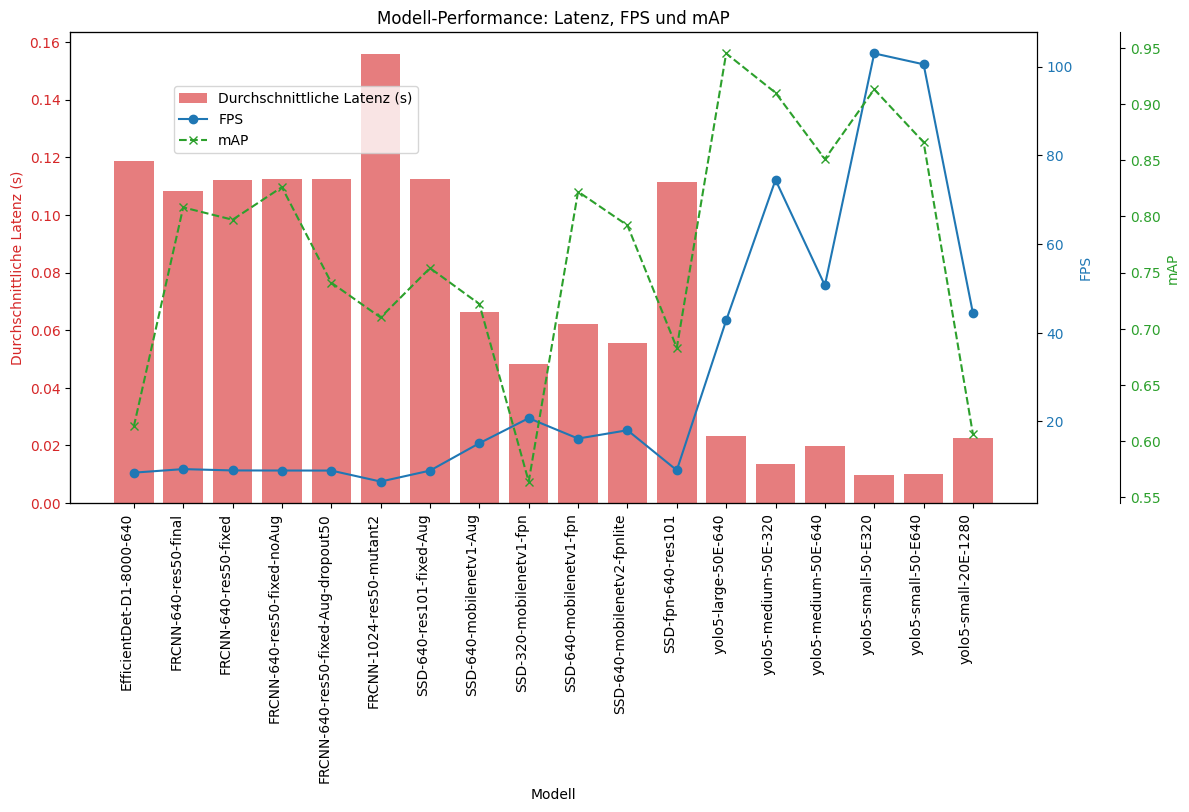

In [155]:
data = {
    'Modell': [
        'EfficientDet-D1-8000-640',
        'FRCNN-640-res50-final',
        'FRCNN-640-res50-fixed',
        'FRCNN-640-res50-fixed-noAug',
        'FRCNN-640-res50-fixed-Aug-dropout50',
        'FRCNN-1024-res50-mutant2',
        'SSD-640-res101-fixed-Aug',
        'SSD-640-mobilenetv1-Aug',
        'SSD-320-mobilenetv1-fpn',
        'SSD-640-mobilenetv1-fpn',
        'SSD-640-mobilenetv2-fpnlite',
        'SSD-fpn-640-res101',
        'yolov5-large-50E-640',
        'yolov5-medium-50E-320', 
        'yolov5-medium-50E-640',
        'yolov5-small-50E-320',
        'yolov5-small-50E-640',
        'yolov5-small-20E-1280',
    ],
    'Durchschnittliche Latenz (s)': [
        0.1186,  # EfficientDet-D1-8000-640
        0.1083,  # FRCNN-640-res50-final
        0.1120,  # FRCNN-640-res50-fixed
        0.1123,  # FRCNN-640-res50-fixed-noAug
        0.1123,  # FRCNN-640-res50-fixed-Aug-dropout50
        0.1557,  # FRCNN-1024-res50-mutant2
        0.1125,  # SSD-640-res101-fixed-Aug
        0.0664,  # SSD-640-mobilenetv1-Aug
        0.0483,  # SSD-320-mobilenetv1-fpn
        0.0620,  # SSD-640-mobilenetv1-fpn
        0.0556,  # SSD-640-mobilenetv2-fpnlite
        0.1114,
        0.0234,  # yolov5-large-50E-640
        0.0134,  # yolov5-medium-50E-320
        0.0197,  # yolov5-medium-50E-640
        0.0097,  # yolov5-small-50E-320
        0.0099,  # yolov5-small-50E-640
        0.0225   # yolov5-small-20E-1280
    ],

    'FPS': [
        8.43,    # EfficientDet-D1-8000-640
        9.23,    # FRCNN-640-res50-final
        8.93,    # FRCNN-640-res50-fixed
        8.91,    # FRCNN-640-res50-fixed-noAug
        8.90,    # FRCNN-640-res50-fixed-Aug-dropout50
        6.42,    # FRCNN-1024-res50-mutant2
        8.89,    # SSD-640-res101-fixed-Aug
        15.07,   # SSD-640-mobilenetv1-Aug
        20.72,   # SSD-320-mobilenetv1-fpn
        16.12,   # SSD-640-mobilenetv1-fpn
        18.00,   # SSD-640-mobilenetv2-fpnlite
        8.97,
        42.77,   # yolov5-large-50E-640
        74.46,   # yolov5-medium-50E-320
        50.67,   # yolov5-medium-50E-640
        102.99,  # yolov5-small-50E-320
        100.53,  # yolov5-small-50E-640
        44.36,   # yolov5-small-20E-1280
    ],
    'mAP': [
        0.613, 0.808, 0.797, 0.826,
        0.741, 0.710, 0.754, 0.722, 0.564,
        0.822, 0.792, 0.683, 0.945, 0.910,
        0.851, 0.913, 0.866, 0.606
    ]
}

df = pd.DataFrame(data)

fig, ax1 = plt.subplots(figsize=(12, 8))


color = 'tab:red'
ax1.set_xlabel('Modell')
ax1.set_ylabel('Durchschnittliche Latenz (s)', color=color)
ax1.bar(df['Modell'], df['Durchschnittliche Latenz (s)'], color=color, alpha=0.6, label='Durchschnittliche Latenz (s)')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticklabels(df['Modell'], rotation=90, ha='right')


ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('FPS', color=color)
ax2.plot(df['Modell'], df['FPS'], color=color, marker='o', label='FPS')
ax2.tick_params(axis='y', labelcolor=color)

ax3 = ax1.twinx()
color = 'tab:green'
ax3.spines['right'].set_position(('outward', 60))
ax3.set_ylabel('mAP', color=color)
ax3.plot(df['Modell'], df['mAP'], color=color, marker='x', linestyle='--', label='mAP')
ax3.tick_params(axis='y', labelcolor=color)


fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1,0.9), bbox_transform=ax1.transAxes)

plt.title('Modell-Performance: Latenz, FPS und mAP')
plt.show()

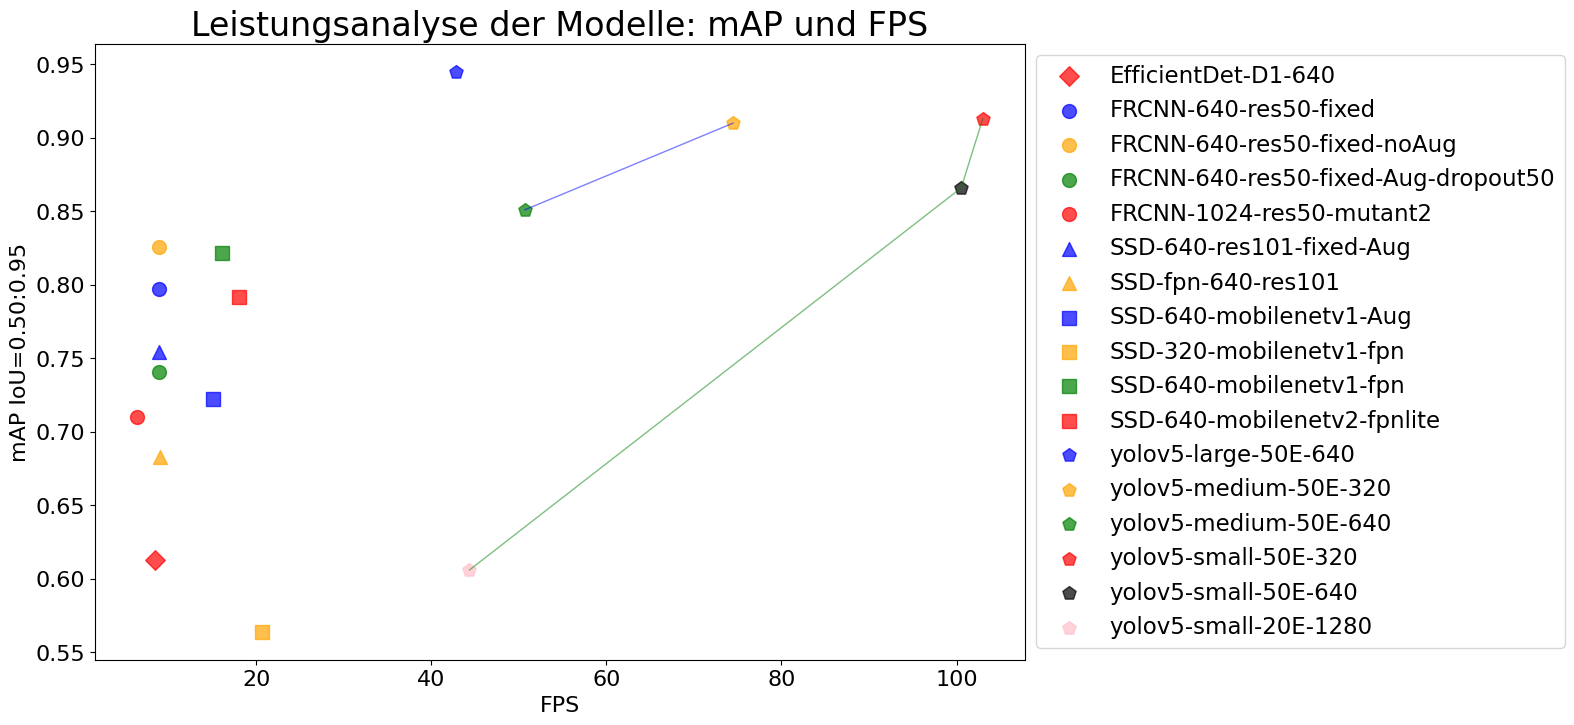

In [157]:
fig, ax = plt.subplots(figsize=(12, 8))

for group, models in groups.items():
    group_df = df[df['Modell'].isin(models)]
    colors = group_colors[group]
    marker = markers[group]
    for i, (index, row) in enumerate(group_df.iterrows()):
        color = colors[i % len(colors)]  
        ax.scatter(row['FPS'], row['mAP'], color=color, marker=marker, s=100, alpha=0.7, label=row['Modell'])
    
    if group == 'yolo5':
        small_models = ['yolov5-small-50E-320', 'yolov5-small-50E-640', 'yolov5-small-20E-1280']
        small_df = group_df[group_df['Modell'].isin(small_models)]
        ax.plot(small_df['FPS'], small_df['mAP'], color='green', linestyle='-', linewidth=1, alpha=0.5)

        medium_models = ['yolov5-medium-50E-320', 'yolov5-medium-50E-640']
        medium_df = group_df[group_df['Modell'].isin(medium_models)]
        ax.plot(medium_df['FPS'], medium_df['mAP'], color='blue', linestyle='-', linewidth=1, alpha=0.5)

ax.set_xlabel('FPS', fontsize=16)
ax.set_ylabel('mAP IoU=0.50:0.95', fontsize=16)
ax.set_title('Leistungsanalyse der Modelle: mAP und FPS', fontsize=24)

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='upper left', bbox_to_anchor=(1, 1), fontsize=16.5)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

In [158]:
%matplotlib inline
#model_name = "SSD-640-mobilenetv1-fpn"
#category_index = label_map_util.create_category_index_from_labelmap(labelmap_path, use_display_name=True)
#tf.keras.backend.clear_session()
#model = tf.saved_model.load('./inference/ssd/SSD_4000_640_mobilenet_v1_fpn/saved_model')

image_path = './GTSRB/Final_Test/Images/*.ppm'
min_score_threshold = 0.4
number_of_images_to_display = 5

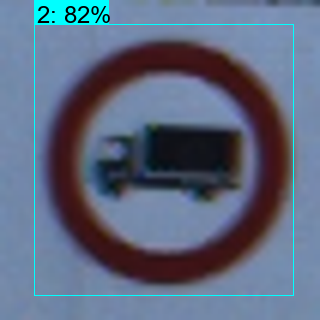

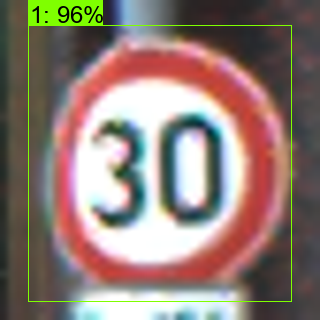

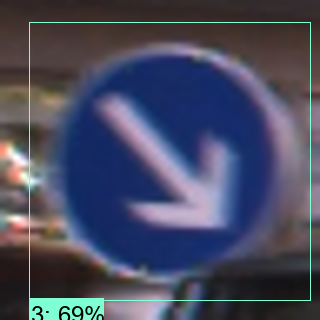

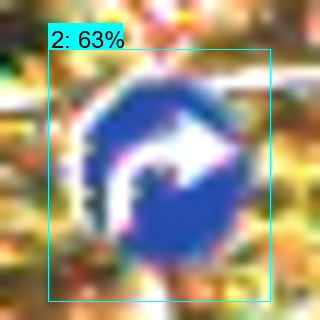

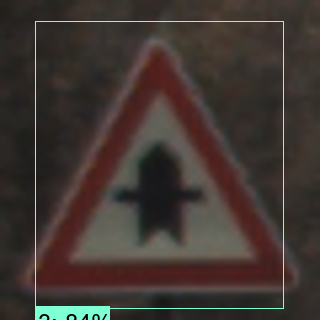

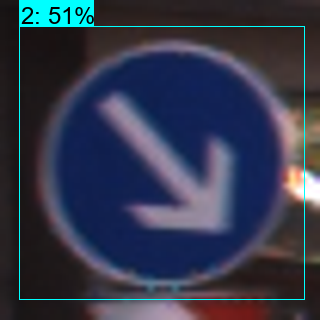

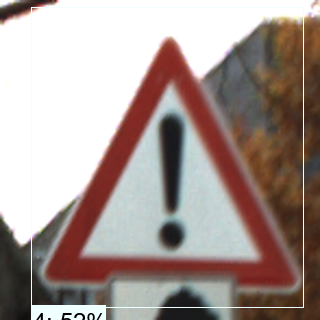

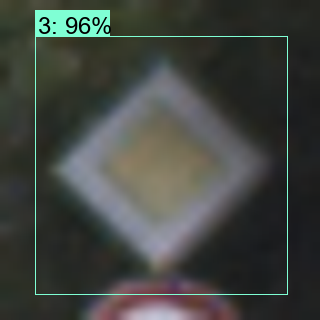

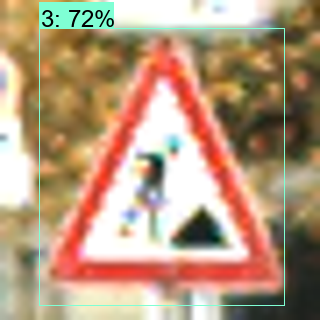

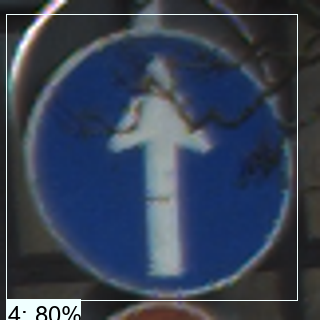

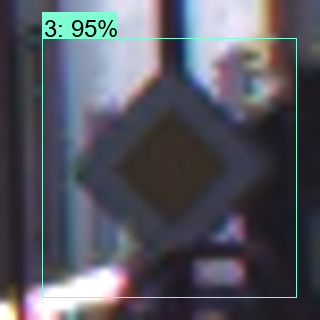

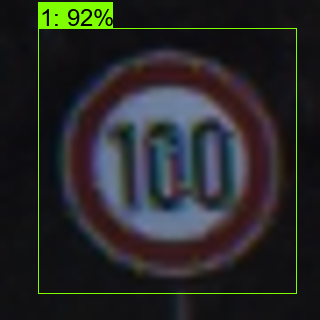

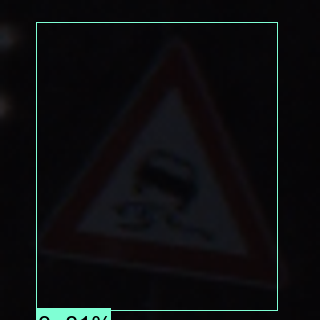

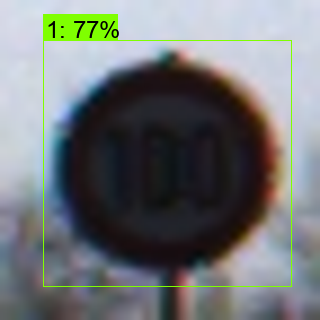

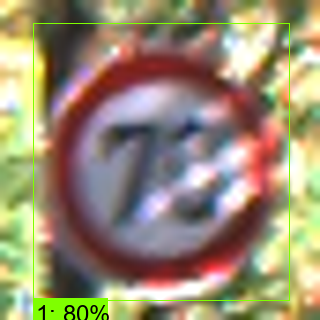

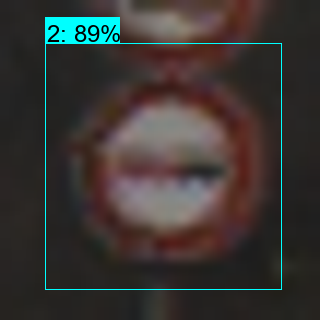

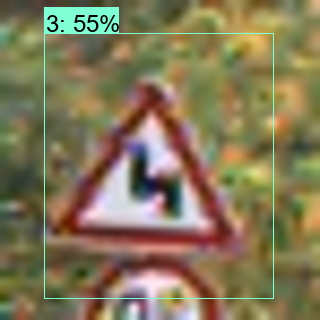

KeyboardInterrupt: 

In [160]:
plot_simple_endless_predictions_from_path(model, image_path, category_index)

In [ ]:
plot_endless_predictions(model, df_final_test, category_index)

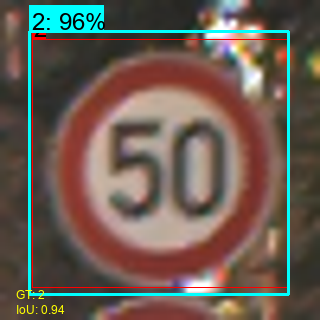

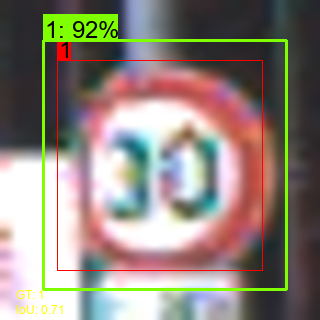

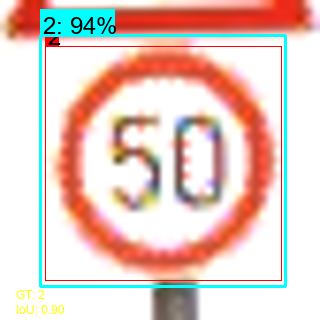

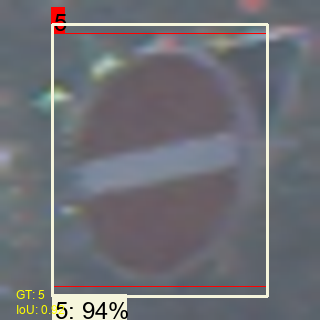

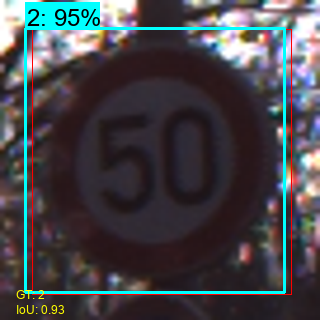

In [162]:
plot_random_predictions_with_groundtruth(model, df_final_test, number_of_images_to_display, category_index)

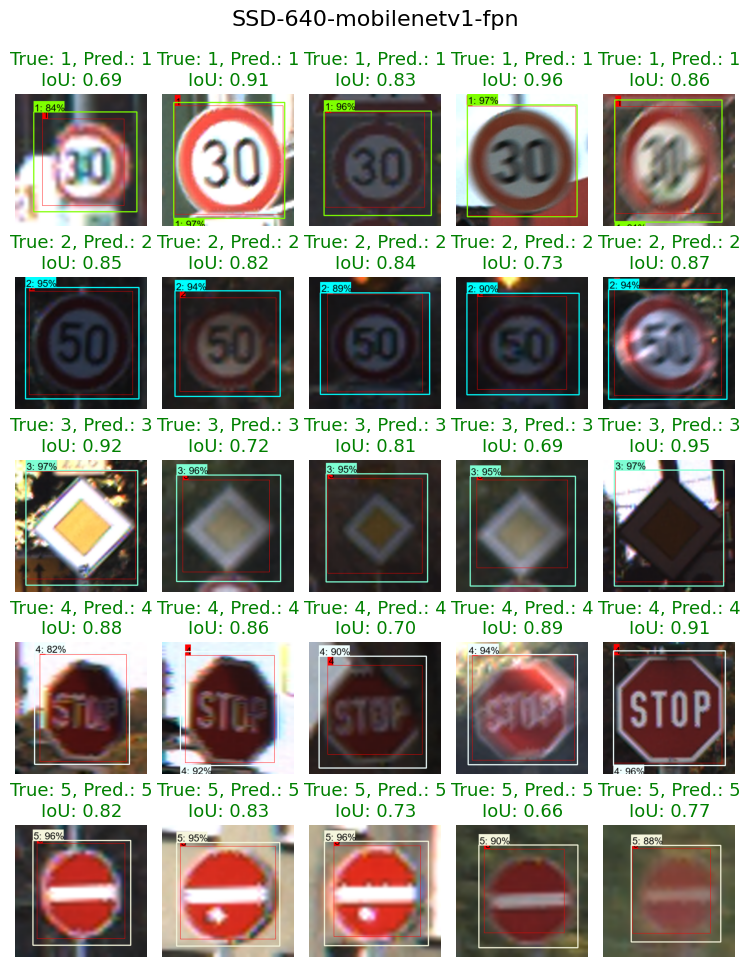

In [159]:
visualize_random_images_for_labels(df_final_test, model, category_index, min_score_threshold, number_of_images_to_display, MODEL_NAME)

### 3.3 Tensorboard plots

In [377]:
model_name = "Faster_RCNN_640_50_fixed"
type = "faster_rcnn"

log_dir = f"D:\\Desktop-Short\\trained_models\\{type}\\{model_name}\\train"

In [369]:
def remove_outliers(steps, values, threshold=3):
    """
    Entferne Ausreißer basierend auf dem Z-Score und passe die Schritte entsprechend an.
    """
    mean = np.mean(values)
    std_dev = np.std(values)
    z_scores = np.abs((values - mean) / std_dev)
    mask = z_scores < threshold
    filtered_steps = np.array(steps)[mask]
    filtered_values = np.array(values)[mask]
    return filtered_steps.tolist(), filtered_values.tolist()

In [381]:
if type == "ssd":
    specific_tags = [
        "Loss/total_loss",
        "Loss/classification_loss",
        "Loss/localization_loss"
    ]

    # Renamed tags
    tag_names = {
        "Loss/total_loss": "Total Loss",
        "Loss/classification_loss": "Classification Loss",
        "Loss/localization_loss": "Localization Loss"
    }
else:
    specific_tags = [
        "Loss/total_loss",
        "Loss/BoxClassifierLoss/classification_loss",
        "Loss/BoxClassifierLoss/localization_loss"
    ]

    tag_names = {
        "Loss/total_loss": "Total Loss",
        "Loss/BoxClassifierLoss/classification_loss": "Classification Loss",
        "Loss/BoxClassifierLoss/localization_loss": "Localization Loss"
    }

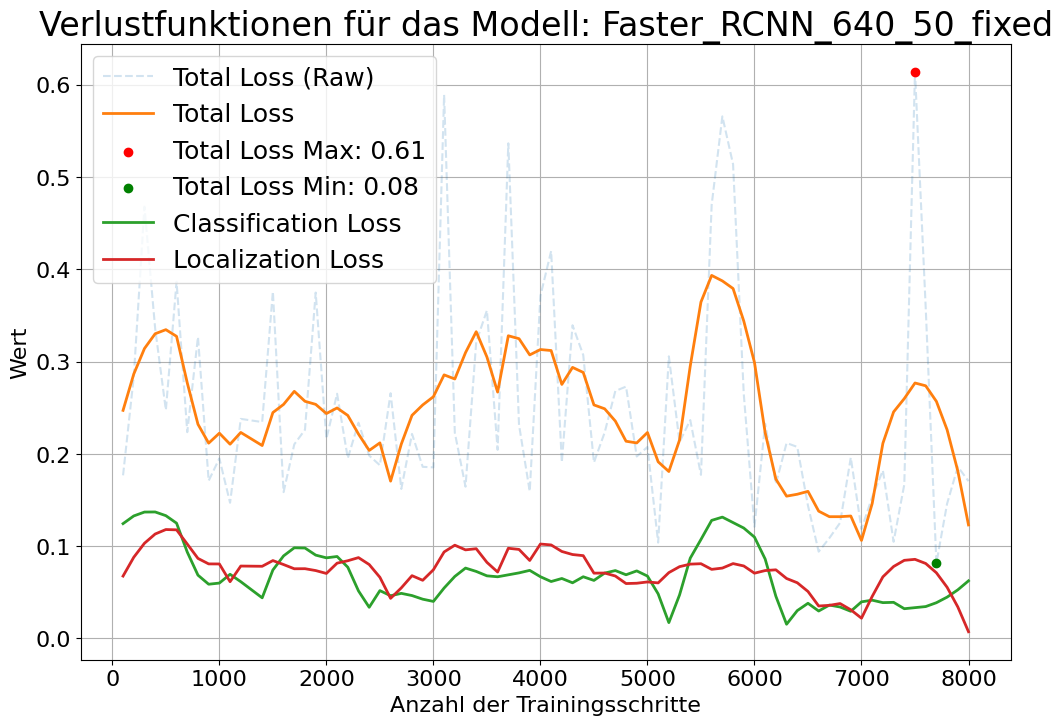

In [382]:
event_acc = EventAccumulator(log_dir, size_guidance={
    'scalars': 0,
    'histograms': 1,
    'images': 1,
    'audio': 1,
    'tensors': 0
})
event_acc.Reload()

tensor_tags = event_acc.Tags()['tensors']

losses = {}
for tensor_tag in specific_tags:
    if tensor_tag in event_acc.Tags()['tensors']:
        tensor_events = event_acc.Tensors(tensor_tag)
        
        steps = []
        values = []

        for e in tensor_events:
            steps.append(e.step)
            v = tf.make_ndarray(e.tensor_proto)
            if v.ndim == 0:
                values.append(v.item())
            elif v.ndim == 1:
                values.extend(v)
            else:
                values.append(np.mean(v))

        filtered_steps, filtered_values = remove_outliers(steps, values)
        losses[tensor_tag] = (filtered_steps, filtered_values)
        
plt.figure(figsize=(12, 8))

window_size = 11  
poly_order = 2    

for tensor_tag, (steps, values) in losses.items():
    loss_name = tag_names.get(tensor_tag, tensor_tag)
    
    if len(values) > window_size:
        smoothed_values = savgol_filter(values, window_size, poly_order)
        
        if tensor_tag == "Loss/total_loss":
            plt.plot(steps, values, label=f'{loss_name} (Raw)', linestyle='--', alpha=0.2)
            plt.plot(steps, smoothed_values, label=f'{loss_name}', linewidth=2)
            
            min_index = np.argmin(values)
            max_index = np.argmax(values)
            
            plt.scatter(steps[max_index], values[max_index], color='red', zorder=5, label=f'{loss_name} Max: {values[max_index]:.2f}')
            plt.scatter(steps[min_index], values[min_index], color='green', zorder=5, label=f'{loss_name} Min: {values[min_index]:.2f}')

        else:
            plt.plot(steps, smoothed_values, label=f'{loss_name}', linewidth=2)
    else:
        print(f"Nicht genügend Daten für {loss_name} zur Glättung")

plt.xlabel("Anzahl der Trainingsschritte", fontsize=16)
plt.ylabel("Wert", fontsize=16)
plt.title(f"Verlustfunktionen für das Modell: {model_name}", fontsize=24)
plt.legend(fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.show()

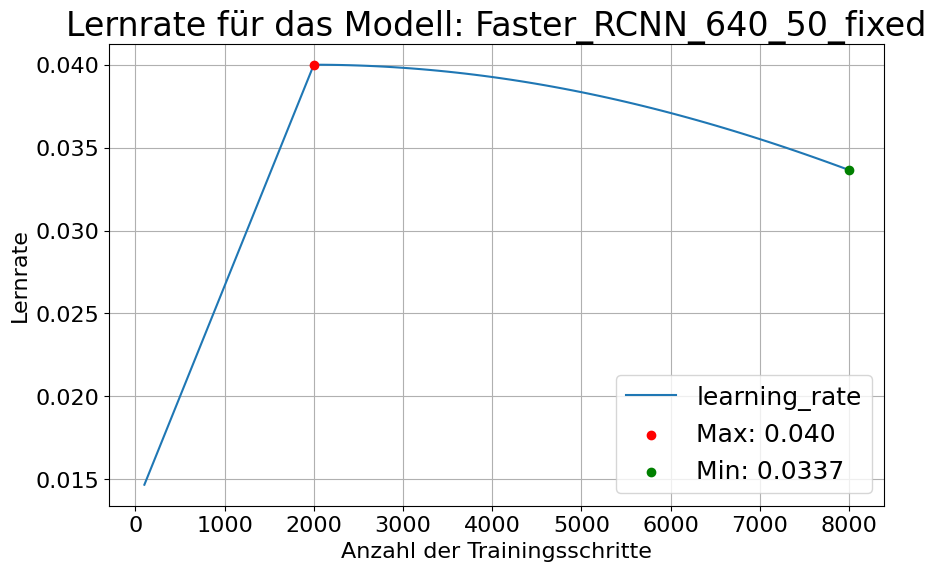

In [383]:
specific_tags = ["learning_rate"]

event_acc = EventAccumulator(log_dir, size_guidance={
    'scalars': 0,
    'histograms': 1,
    'images': 1,
    'audio': 1,
    'tensors': 0
})
event_acc.Reload()

tensor_tags = event_acc.Tags()['tensors']

losses = {}
for tensor_tag in specific_tags:
    if tensor_tag in event_acc.Tags()['tensors']:
        tensor_events = event_acc.Tensors(tensor_tag)
        
        steps = []
        values = []

        for e in tensor_events:
            steps.append(e.step)
            v = tf.make_ndarray(e.tensor_proto)
            if v.ndim == 0:
                values.append(v.item())
            elif v.ndim == 1:
                values.extend(v)
            else:
                values.append(np.mean(v))


        losses[tensor_tag] = (filtered_values)
        
    plt.figure(figsize=(10, 6))
    plt.plot(steps, values, label=tensor_tag)
    
    min_index = np.argmin(values)-1
    max_index = np.argmax(values)
    
    plt.scatter(steps[max_index], values[max_index], color='red', zorder=5, label=f'Max: {values[max_index]:.3f}')
    plt.scatter(steps[min_index], values[min_index], color='green', zorder=10, label=f'Min: {values[min_index]:.3}')

    plt.xlabel("Anzahl der Trainingsschritte", fontsize=16)
    plt.ylabel("Lernrate", fontsize=16)
    plt.title(f"Lernrate für das Modell: {model_name}", fontsize=24)
    plt.legend(fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(True)
    plt.show() 

## 4. Realtime detection from streams and videos

### 4.1 Simple Webcam detection

In [ ]:
INFERENCE_MODEL = "Faster_RCNN_50_640_Step_4"
TRAINED_CONFIG_PATH = "./myModules/configs/{name}_config.config".format(name=INFERENCE_MODEL)
TRAINED_CHECKPOINT_PATH = 'D:\\Desktop-Short\\trained_models\\{type}\\{name}'.format(name=INFERENCE_MODEL, type="faster_rcnn")
#TRAINED_CHECKPOINT_PATH = "./inference/faster_rcnn/Faster_RCNN_640_50_fixed_withAugmentation_noUnknown/checkpoint/"
TRAINED_LABLE_MAP_PATH = "./myModules/label_map_short_woUnk.pbtxt"

In [ ]:
configs = config_util.get_configs_from_pipeline_file(TRAINED_CONFIG_PATH)
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(get_latest_checkpoint(TRAINED_CHECKPOINT_PATH)).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections


category_index = label_map_util.create_category_index_from_labelmap(TRAINED_LABLE_MAP_PATH, use_display_name=True)
tf.keras.backend.clear_session()

In [ ]:
category_index = label_map_util.create_category_index_from_labelmap(TRAINED_LABLE_MAP_PATH, use_display_name=True)
tf.keras.backend.clear_session()
model = tf.saved_model.load('./inference/faster_rcnn/{name}/saved_model/'.format(name=INFERENCE_MODEL))

In [ ]:
def run_inference_for_single_image(image):
    
    input_tensor = tf.convert_to_tensor(np.expand_dims(image, 0), dtype=tf.float32)
    #input_tensor = input_tensor[tf.newaxis,...]
    output_dict = detect_fn(input_tensor)
    
    num_detections = int(output_dict.pop('num_detections'))
    output_dict = {key: value[0, :num_detections].numpy() for key, value in output_dict.items()}
    output_dict['num_detections'] = num_detections
    output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
    
    if 'detection_masks' in output_dict:
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            output_dict['detection_masks'], output_dict['detection_boxes'],
            image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5, tf.uint8)
        output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
    return output_dict

In [ ]:
def show_inference(frame):
    
    image_np = np.array(frame)
    output_dict = run_inference_for_single_image(image_np)
    #output_dict = apply_nms(output_dict)  # NMS anwenden
    height, width, _ = image_np.shape

    # Konvertiere normalisierte Koordinaten in Pixelkoordinaten
    for i in range(output_dict['detection_boxes'].shape[0]):
        ymin, xmin, ymax, xmax = output_dict['detection_boxes'][i]
        output_dict['detection_boxes'][i] = [ymin * height, xmin * width, ymax * height, xmax * width]
    
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes']+1,
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks_reframed', None),
        use_normalized_coordinates=False,
        max_boxes_to_draw=10,
        min_score_thresh=0.6,
        agnostic_mode=False,
        line_thickness=5)
    return image_np

In [ ]:
def apply_nms(output_dict, iou_threshold=0.4):
    boxes = output_dict['detection_boxes']
    scores = output_dict['detection_scores']
    classes = output_dict['detection_classes']
    
    selected_indices = tf.image.non_max_suppression(
        boxes=boxes,
        scores=scores,
        max_output_size=output_dict['num_detections'],
        iou_threshold=iou_threshold,
        score_threshold=0.4
    )
    
    selected_boxes = tf.gather(boxes, selected_indices).numpy()
    selected_scores = tf.gather(scores, selected_indices).numpy()
    selected_classes = tf.gather(classes, selected_indices).numpy()
    
    output_dict['detection_boxes'] = selected_boxes
    output_dict['detection_scores'] = selected_scores
    output_dict['detection_classes'] = selected_classes
    output_dict['num_detections'] = len(selected_boxes)
    
    return output_dict

In [ ]:
# Simple webcam
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break
           
    if len(frame.shape) == 2:  
        frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2RGB)
        
    frame_with_detections = show_inference(frame)
    
    cv2.imshow('object detection', cv2.resize(frame_with_detections, (800,600)))


    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

In [ ]:
# Webcam with FPS
cap = cv2.VideoCapture(0)

frame_count = 0
start_time = time.time()
fps = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame_with_detections = show_inference(frame)

    frame_count += 1
    if (time.time() - start_time) > 1:  
        fps = frame_count / (time.time() - start_time)
        frame_count = 0
        start_time = time.time()

    cv2.putText(frame_with_detections, f"FPS: {fps:.2f}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)

    cv2.imshow('Object Detection', frame_with_detections)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

In [ ]:
# Unused 
def show_inference_sliding_window(frame):
    height, width, _ = frame.shape
    window_size = 300  # Größe des Sliding Windows
    step_size = 100    # Schrittweite für das Sliding Window
    
    boxes = []
    classes = []
    scores = []

    for y in range(0, height, step_size):
        for x in range(0, width, step_size):
            window = frame[y:y+window_size, x:x+window_size]
            if window.shape[0] != window_size or window.shape[1] != window_size:
                continue
            
            output_dict = run_inference_for_single_image(window)
            
            for i in range(output_dict['num_detections']):
                box = output_dict['detection_boxes'][i]
                class_id = output_dict['detection_classes'][i]
                score = output_dict['detection_scores'][i]
                
                if score < 0.4:
                    continue
                
                ymin, xmin, ymax, xmax = box
                (left, right, top, bottom) = (int(xmin * window_size) + x, int(xmax * window_size) + x, int(ymin * window_size) + y, int(ymax * window_size) + y)
                boxes.append([top, left, bottom, right])
                classes.append(class_id + 1)
                scores.append(score)
    
    vis_util.visualize_boxes_and_labels_on_image_array(
        frame,
        np.array(boxes),
        np.array(classes),
        np.array(scores),
        category_index,
        use_normalized_coordinates=False,
        max_boxes_to_draw=10,
        min_score_thresh=0.6,
        agnostic_mode=False,
        line_thickness=5)
    
    return frame

In [ ]:
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break
           
    if len(frame.shape) == 2:  
        frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2RGB)
        
    frame_with_detections = show_inference(frame)
    
    cv2.imshow('object detection', frame_with_detections)


    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

In [ ]:
video_capture = cv2.VideoCapture(0)
while True:
    # Capture frame-by-frame
    re,frame = video_capture.read()
    Imagenp=show_inference(model, frame)
    cv2.imshow('object detection', cv2.resize(Imagenp, (800,600)))
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
video_capture.release()
cv2.destroyAllWindows()

### 4.2 Single-Model videoevaluation

In [ ]:
def get_latest_checkpoint(checkpoint_dir):
    checkpoint_files = os.listdir(checkpoint_dir)
    checkpoint_files = [f for f in checkpoint_files if f.startswith('ckpt-') and '.index' in f]
    checkpoint_numbers = [int(re.findall(r'\d+', f)[0]) for f in checkpoint_files]
    if not checkpoint_numbers:
        raise ValueError("No checkpoints found in the directory.")
    latest_checkpoint = max(checkpoint_numbers)
    return os.path.join(checkpoint_dir, f'ckpt-{latest_checkpoint}')

In [ ]:
INFERENCE_MODEL = "SSD_640_mobilenet_v1_fixed_withAugmentation_noUnknown"
MODEL_TYPE = "ssd"

TRAINED_CONFIG_PATH = "./myModules/configs/{name}_config.config".format(name=INFERENCE_MODEL)
TRAINED_CHECKPOINT_PATH = 'D:\\Desktop-Short\\trained_models\\{type}\\{name}'.format(name=INFERENCE_MODEL, type=MODEL_TYPE)
#TRAINED_CHECKPOINT_PATH = "./inference/faster_rcnn/Faster_RCNN_640_50_fixed_withAugmentation_noUnknown/checkpoint/"
TRAINED_LABLE_MAP_PATH = "./myModules/label_map_short_woUnk.pbtxt"

'D:\\Desktop-Short\\trained_models\\faster_rcnn\\{name}'.format(name=MODEL_NAME)

VIDEO_NAME = "30FPS_closeup_allClassesAndUnk"
VIDEO_INPUT_PATH ="./videoInferenceData/30FPS_Closeup/{video}.mp4".format(video=VIDEO_NAME)
VIDEO_OUTPUT_PATH = "D:\\Desktop-Short\\trained_models\\{type}\\{video}\\{name}.mp4".format(name=INFERENCE_MODEL, type=MODEL_TYPE, video=VIDEO_NAME)

In [ ]:
configs = config_util.get_configs_from_pipeline_file(TRAINED_CONFIG_PATH)
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(get_latest_checkpoint(TRAINED_CHECKPOINT_PATH)).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

category_index = label_map_util.create_category_index_from_labelmap(TRAINED_LABLE_MAP_PATH, use_display_name=True)
tf.keras.backend.clear_session()

In [ ]:
def run_inference_for_single_image(image):
    
    input_tensor = tf.convert_to_tensor(np.expand_dims(image, 0), dtype=tf.float32)
    #input_tensor = input_tensor[tf.newaxis,...]
    output_dict = detect_fn(input_tensor)
    
    num_detections = int(output_dict.pop('num_detections'))
    output_dict = {key: value[0, :num_detections].numpy() for key, value in output_dict.items()}
    output_dict['num_detections'] = num_detections
    output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
    
    if 'detection_masks' in output_dict:
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            output_dict['detection_masks'], output_dict['detection_boxes'],
            image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5, tf.uint8)
        output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
    return output_dict

In [ ]:
def show_inference(frame):
    
    image_np = np.array(frame)
    output_dict = run_inference_for_single_image(image_np)
    output_dict = apply_nms(output_dict)  # NMS anwenden
    
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes']+1,
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks_reframed', None),
        use_normalized_coordinates=True,
        max_boxes_to_draw=20,
        min_score_thresh=0.5,
        agnostic_mode=False,
        line_thickness=5)
    return image_np

In [ ]:
def apply_nms(output_dict, iou_threshold=0.4):
    boxes = output_dict['detection_boxes']
    scores = output_dict['detection_scores']
    classes = output_dict['detection_classes']
    
    selected_indices = tf.image.non_max_suppression(
        boxes=boxes,
        scores=scores,
        max_output_size=output_dict['num_detections'],
        iou_threshold=iou_threshold,
        score_threshold=0.4
    )
    
    selected_boxes = tf.gather(boxes, selected_indices).numpy()
    selected_scores = tf.gather(scores, selected_indices).numpy()
    selected_classes = tf.gather(classes, selected_indices).numpy()
    
    output_dict['detection_boxes'] = selected_boxes
    output_dict['detection_scores'] = selected_scores
    output_dict['detection_classes'] = selected_classes
    output_dict['num_detections'] = len(selected_boxes)
    
    return output_dict

In [ ]:
def process_video(input_video_path, output_video_path, show_stream, name, video):
    cap = cv2.VideoCapture(input_video_path)
    
    if not cap.isOpened():
        print(f"Error opening video file {input_video_path}")
        return
    
    output_dir = os.path.dirname(output_video_path)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    if output_video_path:
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))
    else:
        out = None

    frame_count = 0
    total_time = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        start_time = time.time()
        frame_with_detections = show_inference(frame)
        end_time = time.time()

        frame_time = end_time - start_time
        total_time += frame_time
        frame_count += 1

        if out:
            out.write(frame_with_detections)
        
        if show_stream:
            cv2.imshow('object detection', frame_with_detections)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

    cap.release()
    if out:
        out.release()
    cv2.destroyAllWindows()
    
    avg_fps = frame_count / total_time
    with open(f"./myModules/log/{name}_{video}.txt", "w") as f:
                f.write(f"Model:{name}, on Video:{video}\n")
                f.write(f"Processed {frame_count} frames in {total_time:.2f} seconds\n")
                f.write(f"Average FPS: {avg_fps:.2f}")
    print(f"Processed {frame_count} frames in {total_time:.2f} seconds")
    print(f"Average FPS: {avg_fps:.2f}")

In [ ]:
process_video(VIDEO_INPUT_PATH, VIDEO_OUTPUT_PATH, False, INFERENCE_MODEL, VIDEO_NAME)

### 4.3 Multi-Model videoevaluation

In [ ]:
models_to_evaluate = [
    {
        "name": "Efficientdet_8000_640_d1",
        "type": "ssd",
        "label_map": "./myModules/label_map_short_woUnk.pbtxt"
    },
    {
        "name": "SSD_640_101_fixed_withAugmentation_noUnknown2",
        "type": "ssd",
        "label_map": "./myModules/label_map_short_woUnk.pbtxt"
    },
    {
        "name": "SSD_4000_320_mobilenet_v1_fpn",
        "type": "ssd",
        "label_map": "./myModules/label_map_short_woUnk.pbtxt"
    },
    {
        "name": "SSD_4000_640_mobilenet_v1_fpn",
        "type": "ssd",
        "label_map": "./myModules/label_map_short_woUnk.pbtxt"
    },
    {
        "name": "SSD_8000_640_mobilenet_v2_fpnlite",
        "type": "ssd",
        "label_map": "./myModules/label_map_short_woUnk.pbtxt"
    },
    {
        "name": "SSD_8000_640_mobilenet_v2_fpnlite_custom",
        "type": "ssd",
        "label_map": "./myModules/label_map_short_woUnk.pbtxt"
    },
    {
        "name": "SSD_8000_640_resnet101_v1_fpn",
        "type": "ssd",
        "label_map": "./myModules/label_map_short_woUnk.pbtxt"
    },
    {
        "name": "ssd_test",
        "type": "ssd",
        "label_map": "./myModules/label_map_short.pbtxt"
    }
]

In [10]:
VIDEO_NAME = "30FPS_closeup_tracking_allClassesAndUnk"
VIDEO_INPUT_PATH ="./videoInferenceData/30FPS_Closeup/{video}.mp4".format(video=VIDEO_NAME)

In [ ]:
def get_latest_checkpoint(checkpoint_dir):
    checkpoint_files = os.listdir(checkpoint_dir)
    checkpoint_files = [f for f in checkpoint_files if f.startswith('ckpt-') and '.index' in f]
    checkpoint_numbers = [int(re.findall(r'\d+', f)[0]) for f in checkpoint_files]
    if not checkpoint_numbers:
        raise ValueError("No checkpoints found in the directory.")
    latest_checkpoint = max(checkpoint_numbers)
    return os.path.join(checkpoint_dir, f'ckpt-{latest_checkpoint}')

In [11]:
def load_model(config_path, checkpoint_path, label_map_path):
    configs = config_util.get_configs_from_pipeline_file(config_path)
    detection_model = model_builder.build(model_config=configs['model'], is_training=False)
    
    ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
    ckpt.restore(get_latest_checkpoint(checkpoint_path)).expect_partial()
    
    category_index = label_map_util.create_category_index_from_labelmap(label_map_path, use_display_name=True)
    
    @tf.function
    def detect_fn(image):
        image, shapes = detection_model.preprocess(image)
        prediction_dict = detection_model.predict(image, shapes)
        detections = detection_model.postprocess(prediction_dict, shapes)
        return detections
    
    return detect_fn, category_index

In [ ]:
def run_inference_for_single_image(image, detect_fn):
    
    input_tensor = tf.convert_to_tensor(np.expand_dims(image, 0), dtype=tf.float32)
    #input_tensor = input_tensor[tf.newaxis,...]
    output_dict = detect_fn(input_tensor)
    
    num_detections = int(output_dict.pop('num_detections'))
    output_dict = {key: value[0, :num_detections].numpy() for key, value in output_dict.items()}
    output_dict['num_detections'] = num_detections
    output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
    
    if 'detection_masks' in output_dict:
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            output_dict['detection_masks'], output_dict['detection_boxes'],
            image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5, tf.uint8)
        output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
    return output_dict

In [ ]:
def show_inference(frame, category_index, fn):
    
    image_np = np.array(frame)
    output_dict = run_inference_for_single_image(image_np, fn)
    output_dict = apply_nms(output_dict)  # NMS anwenden
    
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes']+1,
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks_reframed', None),
        use_normalized_coordinates=True,
        max_boxes_to_draw=20,
        min_score_thresh=0.5,
        agnostic_mode=False,
        line_thickness=5)
    return image_np

In [12]:
def apply_nms(output_dict, iou_threshold=0.4):
    boxes = output_dict['detection_boxes']
    scores = output_dict['detection_scores']
    classes = output_dict['detection_classes']
    
    selected_indices = tf.image.non_max_suppression(
        boxes=boxes,
        scores=scores,
        max_output_size=output_dict['num_detections'],
        iou_threshold=iou_threshold,
        score_threshold=0.4
    )
    
    selected_boxes = tf.gather(boxes, selected_indices).numpy()
    selected_scores = tf.gather(scores, selected_indices).numpy()
    selected_classes = tf.gather(classes, selected_indices).numpy()
    
    output_dict['detection_boxes'] = selected_boxes
    output_dict['detection_scores'] = selected_scores
    output_dict['detection_classes'] = selected_classes
    output_dict['num_detections'] = len(selected_boxes)
    
    return output_dict

In [13]:
def process_video(input_video_path, show_stream, models):
    # Use the corresponding model settings
    for model_info in models:
        model_name = model_info["name"]
        model_type = model_info["type"]
        label_map_path = model_info["label_map"]
        VIDEO_OUTPUT_PATH = "D:\\Desktop-Short\\videoInferenceModels\\{type}\\{video}\\{name}.mp4".format(name=model_name, type=model_type, video=VIDEO_NAME)
        TRAINED_CONFIG_PATH = f"./myModules/configs/{model_name}_config.config"
        TRAINED_CHECKPOINT_PATH = f'D:\\Desktop-Short\\trained_models\\{model_type}\\{model_name}'
        
        detect_fn, category_index = load_model(TRAINED_CONFIG_PATH, TRAINED_CHECKPOINT_PATH, label_map_path)
        print("Working on:", model_name,model_type, VIDEO_NAME)
        print(VIDEO_OUTPUT_PATH)
        
        output_dir = os.path.dirname(VIDEO_OUTPUT_PATH)
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
            
        cap = cv2.VideoCapture(input_video_path)
        if not cap.isOpened():
            print(f"Error opening video file {input_video_path}")
            return
        
        fps = cap.get(cv2.CAP_PROP_FPS)
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

        if VIDEO_OUTPUT_PATH:

            fourcc = cv2.VideoWriter_fourcc(*'mp4v')
            out = cv2.VideoWriter(VIDEO_OUTPUT_PATH, fourcc, fps, (width, height))
            if not out.isOpened():
                print(f"Error opening video writer {VIDEO_OUTPUT_PATH}")
                return
        else:
            out = None

        frame_count = 0
        total_time = 0

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            
            start_time = time.time()
            frame_with_detections = show_inference(frame, category_index, detect_fn)
            end_time = time.time()

            frame_time = end_time - start_time
            total_time += frame_time
            frame_count += 1

            if out:
                if (frame_with_detections.shape[1], frame_with_detections.shape[0]) == (width, height):
                    out.write(frame_with_detections)
                else:
                    print(f"Frame size mismatch: Expected ({width}, {height}), got ({frame_with_detections.shape[1]}, {frame_with_detections.shape[0]})")
            
            if show_stream:
                cv2.imshow('object detection', frame_with_detections)
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break

        cap.release()
        if out:
            out.release()
        cv2.destroyAllWindows()
        
        avg_fps = frame_count / total_time
        log_dir = "./myModules/log/"
        os.makedirs(log_dir, exist_ok=True)
        log_file_path = os.path.join(log_dir, f"{model_name}_{VIDEO_NAME}.txt")
        with open(log_file_path, "w") as f:
            f.write(f"Model:{model_name}\n")
            f.write(f"Processed {frame_count} frames in {total_time:.2f} seconds\n")
            f.write(f"Average FPS: {avg_fps:.2f}")
        
        print(f"Processed {frame_count} frames in {total_time:.2f} seconds")
        print(f"Average FPS: {avg_fps:.2f}")

In [14]:
process_video(VIDEO_INPUT_PATH, show_stream=False, models=models_to_evaluate)

Working on: SSD_1024_50_mutant ssd 30FPS_closeup_tracking_allClassesAndUnk
D:\Desktop-Short\videoInferenceModels\ssd\30FPS_closeup_tracking_allClassesAndUnk\SSD_1024_50_mutant.mp4
Processed 6464 frames in 2612.58 seconds
Average FPS: 2.47


## 5. Simple Inferencetime Measurement

### 5.1 Single-Model measurement

In [ ]:
model = tf.saved_model.load("./inference/ssd/SSD_4000_640_mobilenet_v1_fpn/saved_model/")

image = load_image_into_numpy_array("./yoloData/Test/images/00007.jpg", height=640, width=640)

num_iterations = 100 
total_time = 0.0

for _ in range(num_iterations):
    start_time = time.time()
    
    predictions = run_inference_for_single_image(image=image, model=model)
    
    end_time = time.time()
    total_time += (end_time - start_time)

average_latency = total_time / num_iterations

print(f"Durchschnittliche Latenz über {num_iterations} Durchläufe: {average_latency:.4f} Sekunden")

### 5.2 Multi-Model measurement

In [ ]:
models_to_test = [
    {"model_name": "Faster_RCNN_50_128_Step_1", "model_path": "./inference/faster_rcnn/Faster_RCNN_50_128_Step_1/saved_model/", "height": 128, "width": 128},
    {"model_name": "Faster_RCNN_50_320_Step_2", "model_path": "./inference/faster_rcnn/Faster_RCNN_50_320_Step_2/saved_model/", "height": 320, "width": 320},
    {"model_name": "Faster_RCNN_50_480_Step_3", "model_path": "./inference/faster_rcnn/Faster_RCNN_50_480_Step_3/saved_model/", "height": 480, "width": 480},
    {"model_name": "Faster_RCNN_50_640_Step_4", "model_path": "./inference/faster_rcnn/Faster_RCNN_50_640_Step_4/saved_model/", "height": 640, "width": 640},
    {"model_name": "Faster_RCNN_50_1024_Step_5", "model_path": "./inference/faster_rcnn/Faster_RCNN_50_1024_Step_5/saved_model/", "height": 1024, "width": 1024},
    {"model_name": "Faster_RCNN_640_50_fixed", "model_path": "./inference/faster_rcnn/Faster_RCNN_640_50_fixed/saved_model/", "height": 640, "width": 640},
    {"model_name": "Faster_RCNN_640_50_fixed_withAugmentation_noUnknown", "model_path": "./inference/faster_rcnn/Faster_RCNN_640_50_fixed_withAugmentation_noUnknown/saved_model/", "height": 640, "width": 640},
    {"model_name": "Faster_RCNN_640_50_fixed_withAugmentation_noUnknown_dropout50", "model_path": "./inference/faster_rcnn/Faster_RCNN_640_50_fixed_withAugmentation_noUnknown_dropout50/saved_model/", "height": 640, "width": 640},
    {"model_name": "Faster_RCNN_short_640_101", "model_path": "./inference/faster_rcnn/Faster_RCNN_short_640_101/saved_model/", "height": 640, "width": 640},
    {"model_name": "Faster_RCNN_640_50_final", "model_path": "./inference/faster_rcnn/Faster_RCNN_640_50_final/saved_model/", "height": 640, "width": 640},
    {"model_name": "Faster_RCNN_1024_50_mutant_2", "model_path": "./inference/faster_rcnn/Faster_RCNN_1024_50_mutant_2/saved_model/", "height": 1024, "width": 1024},
    {"model_name": "Efficientdet_8000_640_d1", "model_path": "./inference/ssd/Efficientdet_8000_640_d1/saved_model/", "height": 640, "width": 640},
    {"model_name": "SSD_640_101_fixed_withAugmentation_noUnknown2", "model_path": "./inference/ssd/SSD_640_101_fixed_withAugmentation_noUnknown2/saved_model/", "height": 640, "width": 640},
    {"model_name": "SSD_640_mobilenet_v1_fixed_withAugmentation_noUnknown", "model_path": "./inference/ssd/SSD_640_mobilenet_v1_fixed_withAugmentation_noUnknown/saved_model/", "height": 640, "width": 640},
    {"model_name": "SSD_640_101_fixed_withAugmentation_noUnknown2", "model_path": "./inference/ssd/SSD_640_101_fixed_withAugmentation_noUnknown2/saved_model/", "height": 640, "width": 640},
    {"model_name": "SSD_1024_101_fixed_withAugmentation_noUnknown", "model_path": "./inference/ssd/SSD_1024_101_fixed_withAugmentation_noUnknown/saved_model/", "height": 1024, "width": 1024},
    {"model_name": "SSD_4000_320_mobilenet_v1_fpn", "model_path": "./inference/ssd/SSD_4000_320_mobilenet_v1_fpn/saved_model/", "height": 320, "width": 320},
    {"model_name": "SSD_4000_640_mobilenet_v1_fpn", "model_path": "./inference/ssd/SSD_4000_640_mobilenet_v1_fpn/saved_model/", "height": 640, "width": 640},
    {"model_name": "SSD_8000_640_mobilenet_v2_fpnlite", "model_path": "./inference/ssd/SSD_8000_640_mobilenet_v2_fpnlite/saved_model/", "height": 640, "width": 640},
    {"model_name": "SSD_8000_640_mobilenet_v2_fpnlite_custom", "model_path": "./inference/ssd/SSD_8000_640_mobilenet_v2_fpnlite_custom/saved_model/", "height": 640, "width": 640},
    {"model_name": "SSD_8000_640_resnet101_v1_fpn", "model_path": "./inference/ssd/SSD_8000_640_resnet101_v1_fpn/saved_model/", "height": 640, "width": 640},
    {"model_name": "SSD_fpn_640_101", "model_path": "./inference/ssd/SSD_fpn_640_101/saved_model/", "height": 640, "width": 640}

]

image_path = "./yoloData/Test/images/00007.jpg"

In [ ]:
def measure_latency(model_path, image_path, height, width, num_iterations=100):
    model = tf.saved_model.load(model_path)
    image = load_image_into_numpy_array(image_path, height, width)
    
    total_time = 0.0

    for _ in range(num_iterations):
        start_time = time.time()
        
        predictions = run_inference_for_single_image(image=image, model=model)
        
        end_time = time.time()
        total_time += (end_time - start_time)

    average_latency = total_time / num_iterations
    fps = 1 / average_latency

    return average_latency, fps

In [ ]:
for model_info in models_to_test:
    model_name = model_info["model_name"]
    model_path = model_info["model_path"]
    height = model_info["height"]
    width = model_info["width"]

    print(f"Modell: {model_name}")
    
    latency, fps = measure_latency(model_path, image_path, height, width)
    
    print(f"Durchschnittliche Latenz: {latency:.4f} Sekunden")
    print(f"FPS: {fps:.2f}\n")

## 6. TFLite for Jetson 

In [ ]:
!python C:\Users\Alexej\Desktop\GTSRB\models\research\object_detection\export_tflite_graph_tf2.py \
    --pipeline_config_path={config_path} \
    --trained_checkpoint_dir={TRAINED_CHECKPOINT_PATH} \
    --output_directory={model_dir}

In [ ]:
FROZEN_TFLITE_PATH = os.path.join(model_dir, 'saved_model')
TFLITE_MODEL = os.path.join(model_dir, 'saved_model', 'detect.tflite')

In [ ]:
saved_dir = 'D:\\Desktop-Short\\trained_models\\ssd\\{name}\\saved_model\\'.format(name=MODEL_NAME)
tflite_model_dir = 'D:\\Desktop-Short\\trained_models\\ssd\\{name}\\saved_model\\detect.tflite'.format(name=MODEL_NAME)

In [ ]:
command = "tflite_convert \
--saved_model_dir={} \
--output_file={} \
--input_shapes=1,300,300,3 \
--input_arrays=normalized_input_image_tensor \
--output_arrays='TFLite_Detection_PostProcess','TFLite_Detection_PostProcess:1','TFLite_Detection_PostProcess:2','TFLite_Detection_PostProcess:3' \
--inference_type=FLOAT \
--allow_custom_ops".format(FROZEN_TFLITE_PATH, TFLITE_MODEL, )

In [ ]:
!tflite_convert --saved_model_dir=Tensorflow\workspace\models\my_ssd_mobnet\tfliteexport\saved_model --output_file=Tensorflow\workspace\models\my_ssd_mobnet\tfliteexport\saved_model\detect.tflite --input_shapes=1,300,300,3 --input_arrays=normalized_input_image_tensor --output_arrays='TFLite_Detection_PostProcess','TFLite_Detection_PostProcess:1','TFLite_Detection_PostProcess:2','TFLite_Detection_PostProcess:3' --inference_type=FLOAT --allow_custom_ops


In [ ]:
!tflite_convert --saved_model_dir=saved_model_dir --output_file=tflite_model_dir

In [ ]:
output_directory = 'tf_lite'

In [ ]:
!python C:\Users\Alexej\Desktop\GTSRB\models\research\object_detection\export_tflite_graph_tf2.py \
    --trained_checkpoint_dir={TRAINED_CHECKPOINT_PATH} \
    --output_directory={output_directory} \
    --pipeline_config_path={config_path}

In [ ]:
!tflite_convert --saved_model_dir=D:\Desktop-Short\trained_models\ssd\ssd_test\saved_model\ --output_file=D:\Desktop-Short\trained_models\ssd\ssd_test\saved_model\model.tflite

In [ ]:
print(tflite_model_dir, saved_model_dir)

In [ ]:
!tflite_convert --saved_model_dir=saved_model_dir --output_file=tflite_model_dir
